In [1]:
import glob
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
import re
import jamotools
import os

import threading
import queue

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import librosa

import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable

import scipy as sp

import random
import copy
from datetime import datetime
import time

In [2]:
data_path = 'D:/aihub/ETRI_metadata.npy'

In [3]:
metadata = np.load(data_path)

In [4]:
n_mels = 80
fs = 16000
frame_length_ms = 50
frame_shift_ms = 25
nsc = int(fs * frame_length_ms / 1000)
nov = nsc - int(fs * frame_shift_ms / 1000)
nhop = int(fs * frame_shift_ms / 1000)
eps = 1e-8
db_ref = 160

In [5]:
print(len(metadata))

mel_path_list = list()
script_list = list()

for i, data in tqdm(enumerate(metadata)):
    pcm_path = data[0]
    txt_data = data[1]
    
    mel_dir = '\\'.join(pcm_path.replace('aihub\\', 'aihub\\mel\\').split('\\')[:-1])
    mel_path = pcm_path.replace('aihub\\', 'aihub\\mel\\').replace('.pcm', '.npy')
    mel_path = mel_path.replace('D:', 'C:')
    
    mel_path_list.append(mel_path)
    script_list.append(txt_data)
#     if not os.path.exists(mel_dir):
#         os.makedirs(mel_dir)
    
#     if not os.path.isfile(mel_path):
        
#         try:
#             with open(pcm_path, 'rb') as pcm_file:
#                 pcm_data = np.fromfile(pcm_file, dtype=np.int16)
#                 y = pcm_data / 2 ** 14

#                 f, t, Zxx = sp.signal.stft(y, fs=fs, nperseg=nsc, noverlap=nov)

#                 Sxx = np.abs(Zxx)

#                 mel_filters = librosa.filters.mel(sr=fs, n_fft=nsc, n_mels=n_mels)
#                 mel_specgram = np.matmul(mel_filters, Sxx)

#                 log_mel_specgram = 20 * np.log10(np.maximum(mel_specgram, eps))
#                 norm_log_mel_specgram = (log_mel_specgram + db_ref) / db_ref

#                 np.save(mel_path, norm_log_mel_specgram)

# #             plt.figure(figsize=(10,10))
# #             plt.imshow(norm_log_mel_specgram, origin='lower')
# #             plt.colorbar()
# #             plt.show()

#         except:
#             print("Error found in {}".format(pcm_path))

620799


In [6]:
korean = re.compile(u'[^, .?!\u1100-\u115e\u1161-\u11A7\u11a8-\u11ff]+') 

no_korean = np.asarray([len(korean.findall(script)) for script in script_list])

In [7]:
valid_idxs = np.where(no_korean == 0)[0]

In [8]:
mel_path_list = [mel_path_list[idx] for idx in valid_idxs]
script_list = [script_list[idx] for idx in valid_idxs]

In [9]:
unicode_jamo_list = list() # List of total hanguel jamos + [' ', ',', '<eos>', 'sos', '!', '?', '-']

# 초성
for unicode in range(0x1100, 0x1113):
    unicode_jamo_list.append(chr(unicode)) # chr: Change hexadecimal to unicode
    
# 중성
for unicode in range(0x1161, 0x1176):
    unicode_jamo_list.append(chr(unicode))
    
# 종성
for unicode in range(0x11A8, 0x11C3):
    unicode_jamo_list.append(chr(unicode))
    
unicode_jamo_list += [' ', '!', ',', '.', '?', '<sos>', '<eos>']
    

unicode_jamo_list.sort()

# '-' symbol represents "blank" in CTC loss system, "blank" has to be the index 0
unicode_jamo_list = ['-'] + unicode_jamo_list

# Check the symbols
print(unicode_jamo_list)

# Check the total number of symbols
print(len(unicode_jamo_list))

['-', ' ', '!', ',', '.', '<eos>', '<sos>', '?', 'ᄀ', 'ᄁ', 'ᄂ', 'ᄃ', 'ᄄ', 'ᄅ', 'ᄆ', 'ᄇ', 'ᄈ', 'ᄉ', 'ᄊ', 'ᄋ', 'ᄌ', 'ᄍ', 'ᄎ', 'ᄏ', 'ᄐ', 'ᄑ', 'ᄒ', 'ᅡ', 'ᅢ', 'ᅣ', 'ᅤ', 'ᅥ', 'ᅦ', 'ᅧ', 'ᅨ', 'ᅩ', 'ᅪ', 'ᅫ', 'ᅬ', 'ᅭ', 'ᅮ', 'ᅯ', 'ᅰ', 'ᅱ', 'ᅲ', 'ᅳ', 'ᅴ', 'ᅵ', 'ᆨ', 'ᆩ', 'ᆪ', 'ᆫ', 'ᆬ', 'ᆭ', 'ᆮ', 'ᆯ', 'ᆰ', 'ᆱ', 'ᆲ', 'ᆳ', 'ᆴ', 'ᆵ', 'ᆶ', 'ᆷ', 'ᆸ', 'ᆹ', 'ᆺ', 'ᆻ', 'ᆼ', 'ᆽ', 'ᆾ', 'ᆿ', 'ᇀ', 'ᇁ', 'ᇂ']
75


In [10]:
# Tokenizer maps numbers to characters, 8 -> 'ㄱ', 10 -> 'ㄴ'
class Tokenizer():
    def __init__(self, vocabs):
        self.vocabs = vocabs
        
    def word2num(self, sentence):
        tokens = list()
        for char in sentence:
            tokens.append(self.vocabs.index(char))    
        return tokens
        
    def word2vec(self, sentence):
        vectors = np.zeros((len(sentence), len(self.vocabs)))
        for i, char in enumerate(sentence):
            vectors[i, self.vocabs.index(char)] = 1   
        return vectors
    
    def num2word(self, num):
        output = list()
        for i in num:
            output.append(self.vocabs[i])
        return output
    
    def num2vec(self, numbers):
        vectors = np.zeros((len(numbers), len(self.vocabs)))
        for i, num in enumerate(numbers):
            vectors[i, num] = 1   
        return vectors
    

In [11]:
# Create tokenizer, put the whole symbols in and check the output 
tokenizer = Tokenizer(unicode_jamo_list)
jamo_tokens = tokenizer.word2num(unicode_jamo_list)

In [12]:
# Create true sentence list, <eos> is added to the end
ground_truth_list = [(tokenizer.word2num(list(script_list[i]) + ['<eos>'])) for i in range(len(script_list))]

In [13]:
print(len(mel_path_list))

print(len(ground_truth_list))

# 80% of the data will be used as train
split_index = int(0.8 * len(mel_path_list))

# Split index is the number stands for 80%
print(split_index)

# Split index is the number stands for 80%
mel_path_list_train = mel_path_list[:split_index]
ground_truth_list_train = ground_truth_list[:split_index]

print(len(mel_path_list_train))

mel_path_list_eval = mel_path_list[split_index:]
ground_truth_list_eval = ground_truth_list[split_index:]

print(len(mel_path_list_eval))

####################################################
# 1/10

mel_path_list_train = mel_path_list_train[:int(len(mel_path_list_train)/10)]
ground_truth_list_train = ground_truth_list_train[:len(mel_path_list_train)]

mel_path_list_eval = mel_path_list_eval[:int(len(mel_path_list_eval)/10)]
ground_truth_list_eval = ground_truth_list_eval[:len(mel_path_list_eval)]

print(len(mel_path_list_train))
print(len(ground_truth_list_train))

print(len(mel_path_list_eval))
print(len(ground_truth_list_eval))

613636
613636
490908
490908
122728
49090
49090
12272
12272


In [14]:
class Encoder(nn.Module):
    def __init__(self, D_in, H):
        super(Encoder, self).__init__()
        
        self.fc = torch.nn.Linear(D_in, H)
        self.relu = torch.nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        
        self.gru = nn.GRU(H, int(H/2), bidirectional=True, batch_first=True)

    def forward(self, input_tensor):
         
        # (B, T, F)
        output_tensor = self.fc(input_tensor)
        output_tensor = self.relu(output_tensor)
        output_tensor = self.dropout(output_tensor)
                
        
        # (B, T, H)
        
        output_tensor, _ = self.gru(output_tensor)
        
        # (B, T, 2 * H/2)
        
        return output_tensor
    
class CTC_Decoder(nn.Module):
    def __init__(self, H, D_out):
        super(CTC_Decoder, self).__init__()
        
        self.fc_embed = nn.Linear(H, H)
        self.relu_embed = torch.nn.ReLU()
        self.dropout_embed = nn.Dropout(p=0.5)
        
        self.gru = nn.GRU(H, D_out, batch_first=True)
        
        self.fc = nn.Linear(D_out, 75)
        self.log_softmax = nn.LogSoftmax(dim=2)

    def forward(self, input_tensor):

        # (B, T, 2 * H/2)
        output_tensor = self.fc_embed(input_tensor)
        output_tensor = self.relu_embed(output_tensor)
        output_tensor = self.dropout_embed(output_tensor)
        
        # (B, T, H)
        output_tensor,_ = self.gru(input_tensor)
        
        # (B, T, H)
        output_tensor = self.fc(output_tensor)
        
        
        # (B, T, 75)
        prediction_tensor = self.log_softmax(output_tensor)

        return prediction_tensor

class Mel2SeqNet():
    def __init__(self, D_in, H, D_out):
        super(Mel2SeqNet, self).__init__()
        
        # Use GPU if GPU is available 
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.encoder = Encoder(D_in, H).to(device)
        self.decoder = CTC_Decoder(H, D_out).to(device)

        self.encoder_optimizer = optim.Adam(self.encoder.parameters(), lr=0.001)
        self.decoder_optimizer = optim.Adam(self.decoder.parameters(), lr=0.001)

        self.ctc_loss = nn.CTCLoss().to(device)
        
        # Initialize weights with random uniform numbers with range
        for param in self.encoder.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.decoder.parameters():
            param.data.uniform_(-0.1, 0.1)

    def train(self, input_tensor, ground_truth, loss_mask, target_lengths):
        
        # Shape of the input tensor (B, T, F)
        # B: Number of a batch (8, 16, or 64 ...)
        # T: Temporal length of an input
        # F: Number of frequency band, 80
        
        batch_size = input_tensor.shape[0]

        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()

        # (B, T, F) -> (B, T, H)
        encoded_tensor = self.encoder(input_tensor)

        # (B, T, H) -> (B, T, 75)
        pred_tensor = self.decoder(encoded_tensor)
            
        # Cast true sentence as Long data type, since CTC loss takes long tensor only
        # Shape (B, S)
        # S: Max length among true sentences 
        truth = ground_truth
        truth = truth.type(torch.cuda.LongTensor)
        
        # CTC loss function takes tensor of the form (T, B, 75)
        # Permute function changes axes of a tensor T <-> B
        pred_tensor = pred_tensor.permute(1, 0, 2)
        
        # CTC loss need to know the lenght of the true sentence
        input_lengths = torch.full(size=(batch_size,), fill_value=pred_tensor.shape[0], dtype=torch.long)
        
        # Calculate CTC Loss
        loss = self.ctc_loss(pred_tensor, truth, input_lengths, target_lengths)
        
        # Calculate loss
        loss.backward()

        # Update weights
        self.encoder_optimizer.step()
        self.decoder_optimizer.step()
        
        # Return loss divided by true length because loss is sum of the character losses
        
        return pred_tensor, loss.item() / ground_truth.shape[1]
    
    
    def test(self, input_tensor, ground_truth, loss_mask, target_lengths):
        
        # Shape of the input tensor (B, T, F)
        # B: Number of a batch (8, 16, or 64 ...)
        # T: Temporal length of an input
        # F: Number of frequency band, 80
        
        batch_size = input_tensor.shape[0]

        # (B, T, F) -> (B, T, H)
        encoded_tensor = self.encoder(input_tensor)

        # (B, T, H) -> (B, T, 75)
        pred_tensor = self.decoder(encoded_tensor)
            
        # Cast true sentence as Long data type, since CTC loss takes long tensor only
        # Shape (B, S)
        # S: Max length among true sentences 
        truth = ground_truth
        truth = truth.type(torch.cuda.LongTensor)
        
        # CTC loss function takes tensor of the form (T, B, 75)
        # Permute function changes axes of a tensor T <-> B
        pred_tensor = pred_tensor.permute(1, 0, 2)
        
        # CTC loss need to know the lenght of the true sentence
        input_lengths = torch.full(size=(batch_size,), fill_value=pred_tensor.shape[0], dtype=torch.long)
        
        # Calculate CTC Loss
        loss = self.ctc_loss(pred_tensor, truth, input_lengths, target_lengths)
        
        # Return loss divided by true length because loss is sum of the character losses
        
        return pred_tensor, loss.item() / ground_truth.shape[1]
    
    def save(self, check_point_name):
        torch.save({
            'encoder_state_dict': self.encoder.state_dict(),
            'decoder_state_dict': self.decoder.state_dict(),
            'encoder_optimizer_state_dict': self.encoder_optimizer.state_dict(),
            'decoder_optimizer_state_dict': self.decoder_optimizer.state_dict(),
            }, check_point_name)
    
    def load(self, check_point_name):
        checkpoint = torch.load(check_point_name)
        self.encoder.load_state_dict(checkpoint['encoder_state_dict'])
        self.decoder.load_state_dict(checkpoint['decoder_state_dict'])
        self.encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
        self.decoder_optimizer.load_state_dict(checkpoint['decoder_optimizer_state_dict'])
        
    def set_mode(self, mode):
        
        # Must call .train() after loading if you want to train again
        if mode == 'train':
            self.encoder.train()
            self.decoder.train()
        
        # Must call .eval() after loading if you do not want to use dropouts
        elif mode == 'eval':
            self.encoder.eval()
            self.decoder.eval()
            
        else:
            print("Invalid mode string: {}".format(mode))
    
# net = Mel2SeqNet(80, 512, 256)

# net = Mel2SeqNet(80, 1024, 512)

net = Mel2SeqNet(80, 1536, 512)

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")      
print(device)

cuda:0


In [16]:
class Batched_Preloader():
    def __init__(self, mel_path_list, ground_truth_list, batch_size):
        super(Batched_Preloader).__init__()
        self.mel_path_list = mel_path_list
        self.total_num_input = len(mel_path_list)
        self.tensor_input_list = [None] * self.total_num_input
        self.ground_truth_list = ground_truth_list
        self.sentence_length_list = np.asarray(list(map(len, ground_truth_list)))
#         self.shuffle_step = 4
        self.shuffle_step = 12
        self.loading_sequence = None
        self.end_flag = True
        self.batch_size = batch_size
    
    # Load the spectrogram image from the disk
    def load(self, i):
        norm_log_mel_specgram = np.load(self.mel_path_list[i])
        
        # (F, T) -> (T, F)
        input_spectrogram = norm_log_mel_specgram.T
        
        # (T, F) -> (1, T, F)
        # Inserted the first axis to make stacking easier
        tensor_input = torch.tensor(input_spectrogram).view(1, input_spectrogram.shape[0], input_spectrogram.shape[1])
        self.tensor_input_list[i] = tensor_input
    
    # Check if tensor number i is already loaded, if not load and returns the image
    def get(self, i):
        if type(self.tensor_input_list[i]) == type(None):
            self.load(i)
        return self.tensor_input_list[i]  
    
    # Try loading every images
    def initialize_preloader(self):
        for i in tqdm(range(self.total_num_input)):
            self.load(i)
        
        return
    
    # Shuffle loading index and set end flag to false
    def initialize_batch(self):
        loading_sequence = np.argsort(self.sentence_length_list)
        bundle = np.stack([self.sentence_length_list[loading_sequence], loading_sequence])
        
        for seq_len in range(self.shuffle_step, np.max(self.sentence_length_list), self.shuffle_step):
            idxs = np.where((bundle[0, :] > seq_len) & (bundle[0, :] <= seq_len + self.shuffle_step))[0]
            idxs_origin = copy.deepcopy(idxs)
            random.shuffle(idxs)
            bundle[:, idxs_origin] = bundle[:, idxs]
            
        loading_sequence = bundle[1, :]
        
        self.loading_sequence = loading_sequence
        self.current_loading_index = 0
        self.end_flag = False
        
        return
    
    # Get batch
    def get_batch(self):
        
        tensor_list = list()
        ground_truth_list = list()
        tensor_size_list = list()
        ground_truth_size_list = list()
        
        count = 0
        max_seq_len = 0
        max_sen_len = 0
        
        for i in range(self.batch_size):
            
            # If there is no more file, break and set end_flag true
            if self.current_loading_index >= self.total_num_input:
                self.end_flag = True
                break
            
            tensor = self.get(self.loading_sequence[self.current_loading_index])
            tensor_list.append(tensor)
            tensor_size_list.append(tensor.shape[1])
            
            ground_truth = self.ground_truth_list[self.loading_sequence[self.current_loading_index]]
            ground_truth_list.append(ground_truth)
            ground_truth_size_list.append(len(ground_truth))
            
            
            if (tensor.shape[1] > max_seq_len):
                max_seq_len = tensor.shape[1]
            if (len(ground_truth) > max_sen_len):
                max_sen_len = len(ground_truth)  
            
            self.current_loading_index += 1
            count += 1
            
        batched_tensor = torch.zeros(count, max_seq_len + 5, n_mels)
        batched_ground_truth = torch.zeros(count, max_sen_len)
        batched_loss_mask = torch.zeros(count, max_sen_len)
        ground_truth_size_list = torch.tensor(np.asarray(ground_truth_size_list), dtype=torch.long)
        
        for order in range(count):
            
            target = tensor_list[order]
        
            pad_random = np.random.randint(0, 5)
            
            # Time shift, add zeros in front of an image
            if pad_random > 0:
                offset = torch.zeros(target.shape[0], pad_random, target.shape[2]).double()
                target = torch.cat((offset, target.double()), 1)
            
            # Add random noise
            target = target + torch.tensor((np.random.random(target.shape) - 0.5) / 20)
        
            # Value less than 0 or more than 1 is clamped to 0 and 1
            target = torch.clamp(target, min=0.0, max=1.0)
            
            batched_tensor[order, :tensor_size_list[order] + pad_random, :] = target
            batched_ground_truth[order, :ground_truth_size_list[order]] = torch.tensor(ground_truth_list[order])
            
            # You do not need to know what loss mask is 
            batched_loss_mask[order, :ground_truth_size_list[order]] = torch.ones(ground_truth_size_list[order])
        
        return batched_tensor, batched_ground_truth, batched_loss_mask, ground_truth_size_list


In [17]:
class Threading_Batched_Preloader():
    def __init__(self, mel_path_list, ground_truth_list, batch_size):
        super(Threading_Batched_Preloader).__init__()
        self.mel_path_list = mel_path_list
        self.total_num_input = len(mel_path_list)
        self.tensor_input_list = [None] * self.total_num_input
        self.ground_truth_list = ground_truth_list
        self.sentence_length_list = np.asarray(list(map(len, ground_truth_list)))
        self.shuffle_step = 12
        self.loading_sequence = None
        self.end_flag = False
        self.batch_size = batch_size
        self.queue = queue.Queue(32)
        self.thread_flags = list()
    
    # Shuffle loading index and set end flag to false
    def initialize_batch(self, thread_num):
        loading_sequence = np.argsort(self.sentence_length_list)
        bundle = np.stack([self.sentence_length_list[loading_sequence], loading_sequence])

        for seq_len in range(self.shuffle_step, np.max(self.sentence_length_list), self.shuffle_step):
            idxs = np.where((bundle[0, :] > seq_len) & (bundle[0, :] <= seq_len + self.shuffle_step))[0]
            idxs_origin = copy.deepcopy(idxs)
            random.shuffle(idxs)
            bundle[:, idxs_origin] = bundle[:, idxs]
            
        loading_sequence = bundle[1, :]
        loading_sequence_len = len(loading_sequence)
        
#         print("Loading Sequence Length: {}".format(loading_sequence_len))
        
        thread_size = int(np.ceil(loading_sequence_len / thread_num))

        load_idxs_list = list()
        for i in range(thread_num):
            start_idx = i * thread_size
            end_idx = (i + 1) * thread_size

            if end_idx > loading_sequence_len:
                end_idx = loading_sequence_len

            load_idxs_list.append(loading_sequence[start_idx:end_idx])
            
#         for i in range(thread_num):
#             print(len(load_idxs_list[i]))

        self.end_flag = False
        
        self.queue = queue.Queue(32)
        self.thread_flags = [False] * thread_num
        
        self.thread_list = [Batching_Thread(self.mel_path_list, self.ground_truth_list, load_idxs_list[i], self.queue, self.batch_size, self.thread_flags, i) for i in range(thread_num)]

        for thread in self.thread_list:
            thread.start()
        return

    def check_thread_flags(self):
        for flag in self.thread_flags:
            if flag == False:
                return False
        
        if (self.queue.empty):
            self.end_flag = True
            return True

        return False

    def get_batch(self):
        while not (self.check_thread_flags()):
            batch = self.queue.get()

            if (batch != None):
                batched_tensor = batch[0]
                batched_ground_truth = batch[1] 
                batched_loss_mask = batch[2]
                ground_truth_size_list = batch[3]

                return batched_tensor, batched_ground_truth, batched_loss_mask, ground_truth_size_list

        return None

class Batching_Thread(threading.Thread):

    def __init__(self, mel_path_list, ground_truth_list, load_idxs_list, queue, batch_size, thread_flags, id):
        
        threading.Thread.__init__(self)
        self.mel_path_list = mel_path_list
        self.ground_truth_list = ground_truth_list
        self.load_idxs_list = load_idxs_list
        self.list_len = len(load_idxs_list)
        self.cur_idx = 0
        self.id = id
        self.queue = queue
        self.batch_size = batch_size 
        self.thread_flags = thread_flags

    def run(self):

        while(self.cur_idx < self.list_len):
            batch = self.batch()
            success = False
            while success == False:
                try:
                    self.queue.put(batch, True)
                    success = True
                except:
                    print("Batching Failed in Thread ID: {}".format(self.id))
                    sleep(1)

        self.thread_flags[self.id] = True
        
#         print("Thread {} finished".foramt(self.id))

        return 

    def batch(self):

        tensor_list = list()
        ground_truth_list = list()
        tensor_size_list = list()
        ground_truth_size_list = list()
        
        count = 0
        max_seq_len = 0
        max_sen_len = 0
        
        for i in range(self.batch_size):
            
            # If there is no more file, break and set end_flag true
            if self.cur_idx >= self.list_len:
                self.end_flag = True
                break
            
            mel_path = self.mel_path_list[self.load_idxs_list[self.cur_idx]]

            tensor = self.load_mel(mel_path)
            tensor_list.append(tensor)
            tensor_size_list.append(tensor.shape[1])
            
            ground_truth = self.ground_truth_list[self.load_idxs_list[self.cur_idx]]
            ground_truth_list.append(ground_truth)
            ground_truth_size_list.append(len(ground_truth))
            
            if (tensor.shape[1] > max_seq_len):
                max_seq_len = tensor.shape[1]
            if (len(ground_truth) > max_sen_len):
                max_sen_len = len(ground_truth)  
            
            self.cur_idx += 1
            count += 1
            
        batched_tensor = torch.zeros(count, max_seq_len + 5, n_mels)
        batched_ground_truth = torch.zeros(count, max_sen_len)
        batched_loss_mask = torch.zeros(count, max_sen_len)
        ground_truth_size_list = torch.tensor(np.asarray(ground_truth_size_list), dtype=torch.long)
        
        for order in range(count):
            
            target = tensor_list[order]
        
            # pad_random = np.random.randint(0, 5)
            
            # # Time shift, add zeros in front of an image
            # if pad_random > 0:
            #     offset = torch.zeros(target.shape[0], pad_random, target.shape[2])
            #     target = torch.cat((offset, target), 1)
            
            # # Add random noise
            # target = target + (torch.rand(target.shape) - 0.5) / 20
        
            # # Value less than 0 or more than 1 is clamped to 0 and 1
            # target = torch.clamp(target, min=0.0, max=1.0)
            
            # batched_tensor[order, :tensor_size_list[order] + pad_random, :] = target

            batched_tensor[order, :tensor_size_list[order], :] = target
            batched_ground_truth[order, :ground_truth_size_list[order]] = torch.tensor(ground_truth_list[order])
            
            # You do not need to know what loss mask is 
            batched_loss_mask[order, :ground_truth_size_list[order]] = torch.ones(ground_truth_size_list[order])
        
        return [batched_tensor, batched_ground_truth, batched_loss_mask, ground_truth_size_list]

    def load_mel(self, mel_path):
        norm_log_mel_specgram = np.load(mel_path)
        # (F, T) -> (T, F)
        input_spectrogram = norm_log_mel_specgram.T
        # (T, F) -> (1, T, F)
        # Inserted the first axis to make stacking easier
        tensor_input = torch.tensor(input_spectrogram).view(1, input_spectrogram.shape[0], input_spectrogram.shape[1])
        return tensor_input

In [18]:
batch_size = 16

num_thread = 3

# preloader_eval = Batched_Preloader(mel_path_list_eval, ground_truth_list_eval, batch_size)
# # preloader_eval.initialize_preloader()

# preloader_train = Batched_Preloader(mel_path_list_train, ground_truth_list_train, batch_size)
# # preloader_train.initialize_preloader()


preloader_eval = Threading_Batched_Preloader(mel_path_list_eval, ground_truth_list_eval, batch_size)
print(len(mel_path_list_eval))
print(len(ground_truth_list_eval))

preloader_train = Threading_Batched_Preloader(mel_path_list_train, ground_truth_list_train, batch_size)
      
print(len(mel_path_list_train))
print(len(ground_truth_list_train))

12272
12272
49090
49090


In [19]:
# Function that interprets the CTC prediction result

def Decode_CTC_Prediction(prediction):
    CTC_pred = prediction.detach().cpu().numpy()
    result = list()
    last_elem = 0
    for i, elem in enumerate(CTC_pred):
        if elem != last_elem and elem != 0:
            result.append(elem)
        
        last_elem = elem
        
    
    result = np.asarray(result)
    
    return result

09-16 00:41:04
09-16 00:42:21
9600/49090
09-16 00:43:48
19200/49090
09-16 00:45:23
28800/49090
09-16 00:47:13
38400/49090
09-16 00:49:27
48000/49090
09-16 00:49:37
Mean Train Loss: 0.06518580552678195
09-16 00:50:09
9600/12272
09-16 00:50:20
Mean Evaluation Loss: 0.07303874804430278


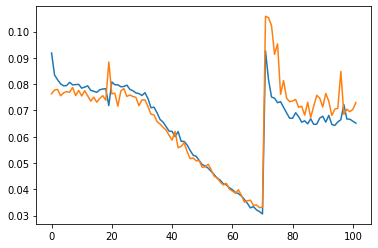

나-------------------으--시--이--으-----그--자--------지---자------시------그---으--아----------그---ᅡ-----그--자---------------------자---아------이-으---자----자---이--자------- 그--스--그---그---------지---이-아---지--이--사----ᅵ----드--자--이--지---대-- 그----기----아---가-----------------------그--아-------이---가-------------------이-ᅵ-ᅵ--ᄋ--이---지---------아---------------------------------------이---ᅵ-------고---고--이------아----으--지-----ᄋ---ᅡ--------그---------그-ᆫ---다--------------그------------------------- -자---가---지---아----ᄋ----ᄋ-----아-------이----그---재-----데---지------------------- 그------가---------ᅵ--------지--- 가------- 가--아--아----이--시---------------ᄋ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

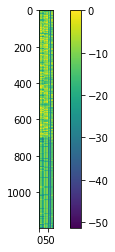

그-----------------------------------ᄀ--------ᅦ------------------------고----------------------가-------다------으----거----다--------------데--------------------------------------------------------------------- 고-----그----------------------------------------------------------------------------가--- 드--으---이------다---------------------------------------------- -ᅡ---------ᄃ-----------------------.<eos><eos>
그게고가다으거다데 고그가 드으이다 ᅡᄃ.<eos>
어저께 거기 쿠폰을 받았는데, 쿠포 쿠폰이 나 보여줬나? 그 카드.<eos>--


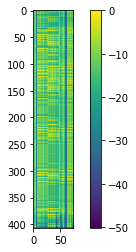

-------------------------------------------------------------------------------------------------------
09-16 00:50:20
09-16 00:51:37
9600/49090
09-16 00:53:05
19200/49090
09-16 00:54:40
28800/49090
09-16 00:56:29
38400/49090
09-16 00:58:42
48000/49090
09-16 00:58:52
Mean Train Loss: 0.06470875387849341
09-16 00:59:24
9600/12272
09-16 00:59:34
Mean Evaluation Loss: 0.07077341468453457


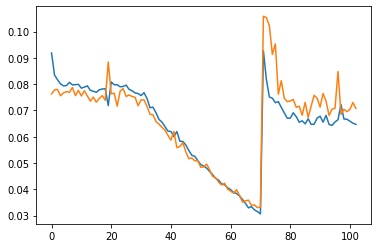

그--------------------------------------드---이--ᅵ--이--고--거---으-이---다--------------------------------------------------------------------------------------------------------------------------------.<eos><eos>
그드이ᅵ이고거으이다.<eos>
돈을 계속 모아놔야겠다.<eos>--------


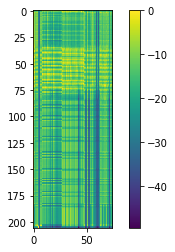

아------------------구-----------가------드----------------------------------------------고-----------아--------------ᄋ----------------- --ᅳ-이---------------- -그-------드--------드-----아-------------------------------수----가--으---------오--어--------------------------------------------------------드-----고------------디--도---------ᆫ--고-----고----그---------------그-----------고------모----ᅵ------------- -그---------스-------------------가-------------------가----이------------------------------------------------------------------------수------------------------그--ᅳ-----소--------이--------ᅡ---------------드---이-----------------가------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

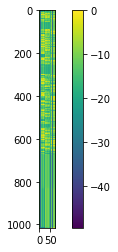

-------------------------------------------------------------------------------------------------------
09-16 00:59:35
09-16 01:00:52
9600/49090
09-16 01:02:19
19200/49090
09-16 01:03:54
28800/49090
09-16 01:05:43
38400/49090
09-16 01:07:58
48000/49090
09-16 01:08:08
Mean Train Loss: 0.0667296682716797
09-16 01:08:40
9600/12272
09-16 01:08:50
Mean Evaluation Loss: 0.07566079451397487


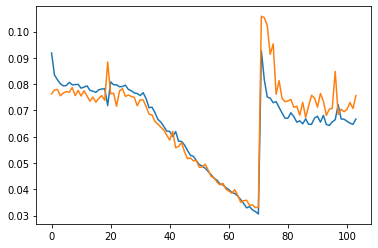

그-----------가---거--고-고---아-ᄋ--어--어----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------.<eos><eos>
그가거고고아ᄋ어어.<eos>
그러고 온도관 이었어.<eos>-----------


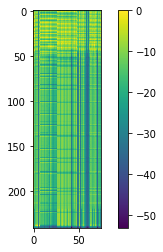

아--------------------------------------------그---ᅳ----ᅵ-----------------시-----시-------------ᅳ-----기------------시------이-----다---------------------------------------------------------------------------------------------------------------------------------------------------------------.<eos><eos>
아그ᅳᅵ시시ᅳ기시이다.<eos>
다음날 그런 얘기가 있을 수 있는데 이러면서 얘기했다매.<eos>-------


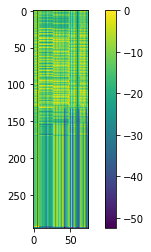

-------------------------------------------------------------------------------------------------------
09-16 01:08:51
09-16 01:10:08
9600/49090
09-16 01:11:35
19200/49090
09-16 01:13:10
28800/49090
09-16 01:14:58
38400/49090
09-16 01:17:12
48000/49090
09-16 01:17:22
Mean Train Loss: 0.0669075461568258
09-16 01:17:54
9600/12272
09-16 01:18:05
Mean Evaluation Loss: 0.06960232394280745


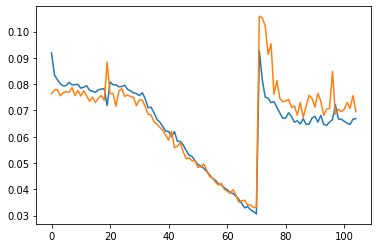

그----------다------------------------  가--------ᄋ-------ᅥ------스------느---애-------시-------고------ᅡ-------이--서----시----------나------나-------------------그------------제-----------------------------------------------------------------------------------------------------.<eos><eos>
그다 가어스느애시고ᅡ이서시나나그제.<eos>
그래서 하루에 벌 수 있는 게 십 오만 원에서 십 육만 원 그 이케<eos>


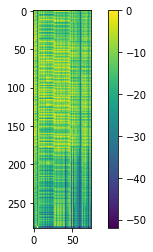

어---------------------------머---드----더------- 가---------데-------------------------------------------------------------------------------------------------------------------------------------------------------------------.<eos><eos>
어머드더 가데.<eos>
아 미용실도 한 번 가야 되는데.<eos>


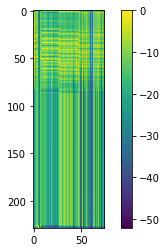

-------------------------------------------------------------------------------------------------------
09-16 01:18:05
09-16 01:19:23
9600/49090
09-16 01:20:50
19200/49090
09-16 01:22:25
28800/49090
09-16 01:24:13
38400/49090
09-16 01:26:28
48000/49090
09-16 01:26:38
Mean Train Loss: 0.06445775485253875
09-16 01:27:11
9600/12272
09-16 01:27:21
Mean Evaluation Loss: 0.07204819904239834


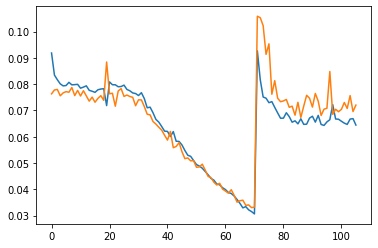

아--------------------------------나-----저-- 이-----아--------------------------- 마------지- -가------ᅡ-  고---애--ᄋ---가-거---거--------- 그---------그------ᅡ---------- 가---ᅡ---으------------------------------------------ -가-----------가--- 개---아---ᆫ--개-------------------------- -ᄀ----거-- -가---------아-- 가----ᅡ- -그--아-ᆫ--더-  고--- -개---------가---가--지----거------시----- 가-------다-----아-----------ᅡ----거---이---가------------------------------------------------------------------ 지---사-------- 가--가---저--거-----가----------ᄋ---기-- 지-- 지----- 사---ᅡ---ᆫ-가----자-------ᅡ----------------------ᅳ--가----ᄀ-----------------이---------지---사-----------가---------개---자--가----가---------대----------------------------------------------------------------- --------ᅵ-----시---------거-------기-----거-어---애----그---ᅩ------이----------그---- 가------자----가-- 가-----가------가------거--------------------기--------그--거-- 고--거--으--이--거--------개--가------가--------

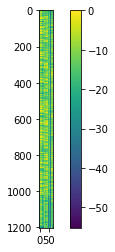

아-------------------------------------- 가---------사---------------------------------------가----ᆫ-나---------아--거------가----------더----------------------------고-----ᄀ--------------------------------------------------------------------------------------------------------------------------------------.<eos><eos>
아 가사간나아거가더고ᄀ.<eos>
알았어. 그 주에 하면 금요일 날 봐도 되는데. 목요일 날이나.<eos>---


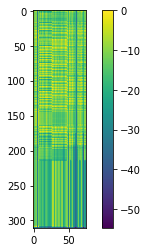

-------------------------------------------------------------------------------------------------------
09-16 01:27:22
09-16 01:28:39
9600/49090
09-16 01:30:06
19200/49090
09-16 01:31:41
28800/49090
09-16 01:33:29
38400/49090
09-16 01:35:43
48000/49090
09-16 01:35:53
Mean Train Loss: 0.06562073643691377
09-16 01:36:25
9600/12272
09-16 01:36:36
Mean Evaluation Loss: 0.06972740395849393


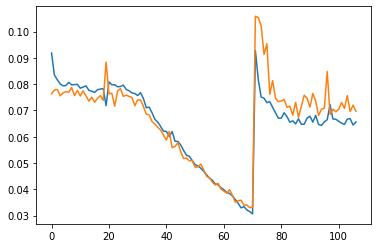

그------------------------------네----- 그------------이------------------ 그----------------그---------------------------------고---으--------아----그------에-------- 지-------ᅡ--------ᆫ--고----------------------------------------------이----서---------이--지--- -ᅳ--나-------데-------------------- 가------------서---------------------------------------------------------------------------------------------------- 가---ᅡ--------------------데--ᄋ-------------------- 차--------ᆫ--고---고-ᆫ---시--- 그------데--------가--------ᆫ-드--으--지-----ᄋ----------서---그---데------------------------------서---------------저--어-----고--------가---------------시-------------ᆫ----모-----마-------------------------------으--------------------------- 가------시--이---머---ᆫ-네--으--므-ᆫ--------------그-----아------으-----지--------지-----에----저---------------------- 가-----시---- 마-ᆫ--서------이---고-----------------------------------게----지----- 고----드-----ᄋ---어-----지------ᅩ---------ᆫ--데--- -ᄃ

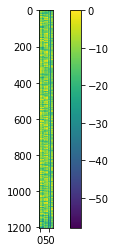

그------------다-----ᆫ-네---이--아---다-------------------그-------------------------------------- 그-ᆫ- 가----ᅥ----지----가--ᅡ---------------------------------------------------------------------------------------------- -믄-아---ᆫ 가--ᆫ---데--------------------아--이-------------------------------------------------------------------------------------지----고-----------------.<eos><eos>
그단네이아다그 근 가ᅥ지가ᅡ 믄안 간데아이지고.<eos>
근데 반대긴 하다 그 돈까스집이랑 여기랑 반대야 위치가 찍고 가?<eos>


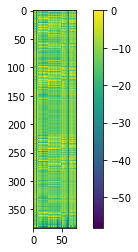

-------------------------------------------------------------------------------------------------------
09-16 01:36:37
09-16 01:37:53
9600/49090
09-16 01:39:21
19200/49090
09-16 01:40:57
28800/49090
09-16 01:42:45
38400/49090
09-16 01:45:00
48000/49090
09-16 01:45:09
Mean Train Loss: 0.0638840476164194
09-16 01:45:41
9600/12272
09-16 01:45:52
Mean Evaluation Loss: 0.06659700075342069


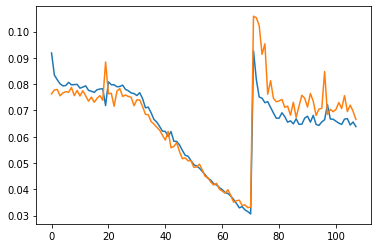

너-----------------------------------사------아--지---마--ᅡ--ᅵ----저---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------.<eos><eos>
너사아지마ᅡᅵ저.<eos>
너 노트북 안 살 거야, 그래서?<eos>--


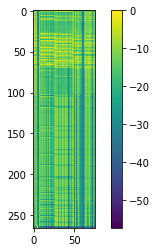

으-----------------------서----거----------아- 마-ᆫ----데---------------------------고------나----나----가-------거-----------------지----------------------------------------------------------------------------------------------------------------------------------------------.<eos><eos>
으서거아 만데고나나가거지.<eos>
우리가 자체적으로 만든 모임이란 말이야. 그것도 심지어<eos>--------


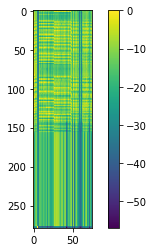

-------------------------------------------------------------------------------------------------------
09-16 01:45:53
09-16 01:47:11
9600/49090
09-16 01:48:38
19200/49090
09-16 01:50:13
28800/49090
09-16 01:52:02
38400/49090
09-16 01:54:16
48000/49090
09-16 01:54:26
Mean Train Loss: 0.06387919295828394
09-16 01:54:58
9600/12272
09-16 01:55:08
Mean Evaluation Loss: 0.06930401096454465


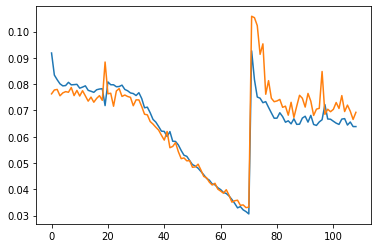

그------------------------------------ᄀ----데-------- --ᅳ--------거----------------어----너------ -마---사---거--저--------------------------------------------------------------------------------------------------------------------------.<eos><eos>
그ᄀ데 ᅳ거어너 마사거저.<eos>
근데 근데 뭐 너두 마찬가지잖아.<eos>


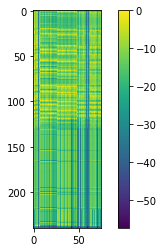

나-----------------------------------------------------나-----느--------------------------------------------고--------거---ᅡ-----으----------나---ᆻ-지-----------------------------------------------------------.<eos><eos>
나나느고거ᅡ으났지.<eos>
나 나는 뭐 공부하면 나지. 음.<eos>-


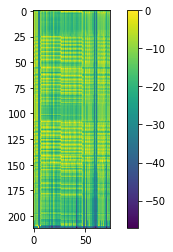

-------------------------------------------------------------------------------------------------------
09-16 01:55:09
09-16 01:56:26
9600/49090
09-16 01:57:53
19200/49090
09-16 01:59:28
28800/49090
09-16 02:01:17
38400/49090
09-16 02:03:31
48000/49090
09-16 02:03:41
Mean Train Loss: 0.06311261946243314
09-16 02:04:13
9600/12272
09-16 02:04:24
Mean Evaluation Loss: 0.06824053525246476


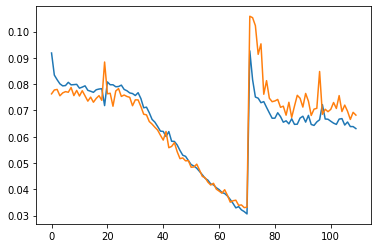

나------------------머----치-----모----모------아--------고-----으--이---그----------------- 다--------ᅵ-----이-------------ᄋ----그--ᄋ------조--오----고-----도-----드------------------모--여---마-----어----모-----서-------머----드------고----지--------- 고--고--ᄋ---저----- 고--모-----------가-------------------수--------어--------므-------------오-거-----고---시-------------고-------------------------드----다-----고--고------------마------오----사-----이--시-------- 다-------------------------------지--------------------구----곤---사-----------지--고-모------ᅡ---서----고------------시------ᅡ----ᄋ--------도----------마------아--ᆫ-느----ᅵ-도---지----그---어--------------그--다--고---서------이---------다--하--고--시------마-----마---------시---이이------가-------마------서------오---어-----ᄋ--으---머----거-------이-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

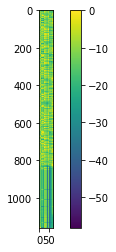

자------------------서-----드----그----------------------------드-------나-------------------------------------------------------------------------------------------으---게------아---ᆫ--모----안--아--ᄋ----어-------------------------------------------------------------------------------------------------------------------.<eos><eos>
자서드그드나으게안모안아ᄋ어.<eos>
거기서 육회? 육회나 이런 거 먹으면서 육회 안 먹어봤냐? 거기서?<eos>


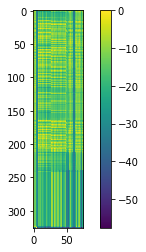

-------------------------------------------------------------------------------------------------------
09-16 02:04:25
09-16 02:05:42
9600/49090
09-16 02:07:09
19200/49090
09-16 02:08:44
28800/49090
09-16 02:10:33
38400/49090
09-16 02:12:47
48000/49090
09-16 02:12:56
Mean Train Loss: 0.06415959206514649
09-16 02:13:29
9600/12272
09-16 02:13:39
Mean Evaluation Loss: 0.06830775507765001


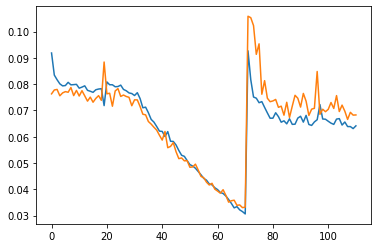

그-------------사-----거--시------거----니- 세--는-거--이----------------------------------------------------------------------------------------------------------------------------------------------------------------.<eos><eos>
그사거시거니 세는거이.<eos>
나 사고 싶은 게 생겼어.<eos>--------


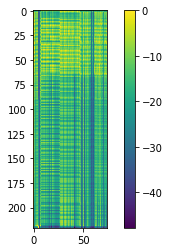

그---------------ᅥ---거--서-----머-----스-----대------도--------데----------------------------------------------------------------------------------------------------------------------------------------------------------------------------.<eos><eos>
그ᅥ거서머스대도데.<eos>
그때 너가 전화했을 때쯤 깼어.<eos>


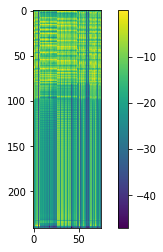

-------------------------------------------------------------------------------------------------------
09-16 02:13:40
09-16 02:14:57
9600/49090
09-16 02:16:24
19200/49090
09-16 02:17:59
28800/49090
09-16 02:19:48
38400/49090
09-16 02:22:02
48000/49090
09-16 02:22:12
Mean Train Loss: 0.0643334216685681
09-16 02:22:44
9600/12272
09-16 02:22:55
Mean Evaluation Loss: 0.06853735975825742


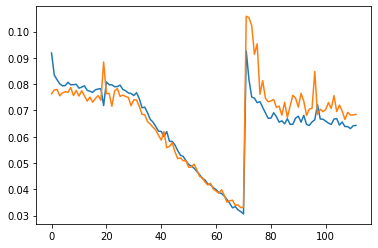

가--------------------------------------------ᅵ------------------------------------나-아--가--고----자--------거--지- -고---ᄋ--으--어--어---- 지-----------------------사---- 아-----더-----이--------서--- 그--이------지---지---------사-----아----그-----으--으-------저------ᅡ------------------------가-----더-거----드--즈--오--오---아--시--사--ᅡ----------오------다------아-----------------ᄀ---지-----다--그-------지---아------저------------------------------- 고-------ᅩ--으----지--어--에-----ᄃ-------에-------------------- 그--------디--즈---소---가---사---도-------으---고---------ᅳ-------------------- 가------그--지----------가-----가--가-아------더--서-----거--------------- 고---ᅵ---------아- 거----가---ᅥ----------------------- 가-------오----으-------지---ᅵ--개------아---서-아-아--거---어--지-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

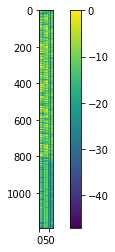

그----------------------------------더------- 그------데---------------------------- -그----드------즈----ᆫ----------------------지------------더-----마------이----------------이------아--- 나---------드------지-------------------------------------------------------------------------------------으--------ᆫ--즈---서------------------ -저-----시---다------이------아------사----- 마---가---------더------ᅳᆫ---------드----------------------------------- 그---- 드-----도------드-------------------지-------------------- 다------더--나--ᅡ--------ᆫ--느---------드-------------------- 도----ᅡ-- 나------니------- 나------ᅳ---이----더--스-----으--ᄋ---사--ᅡ------다-아-ᆫ-도---는-디--디--서----든----ᆫ---디------------------------------------------ 가--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

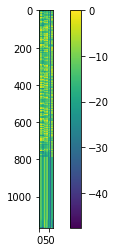

-------------------------------------------------------------------------------------------------------
09-16 02:22:56
09-16 02:24:13
9600/49090
09-16 02:25:40
19200/49090
09-16 02:27:15
28800/49090
09-16 02:29:04
38400/49090
09-16 02:31:17
48000/49090
09-16 02:31:27
Mean Train Loss: 0.06451610134921275
09-16 02:32:00
9600/12272
09-16 02:32:10
Mean Evaluation Loss: 0.06957575394894508


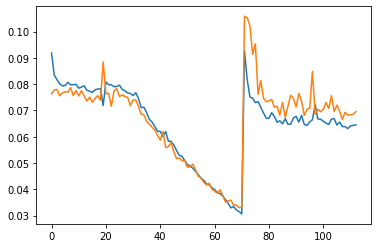

가------------------------------------------------------------------------ 다--아-----서--------ᅡ----그---------------------------------  -지- 아---그-----서-------------------------- 데---아-------- 자-------ᅡ---가---- 마---아--하----------시--시----ᅡ--- 다------ 사----- 도--이--라--모--------------------------네---이-----ᅡ------------아--ᅡ----------------드---ᅵ-----아------고------------------------------ -가-이-- 다---ᅡ------------------------------ 까----ᅡ------------- -그-----네-------------ᅡ----지---------ᄉ-------ᅡ---ᅡ---ᅡ- 므--이- 다--ᄋ----  고- 거------사----자- 가---- 저--- 자----시----------지--다---------지--거--------------------------------지---------자----제--지---------ᄋ-----든- 아----- 고-------도-------------------------------  고--------------------------ᅡ---------------------ᅡ---------------  가------------- 가-----가------ᅡ----ᅡ-------------------------------------   자----------오-가----가- 거-- 지---------대------ᅡ----------------------------------------------- -

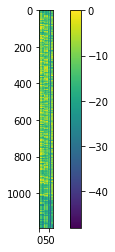

자--------------------------------------------------- 다---- 거----------- 고- 가----------란--모----저-------------------------------------------------------고-----------------------------------------지---------다----------------------- 고 가- -소- 머---자--다----도----------------------------------------- 고----데----다-------------------------가--------------------------------------------------------- 모--사-----------마------ 드------------ 드---- 가----므-- 자---ᅡ-----ᅡ-- 그----------- 아---ᅡ---- 사-------르-ᆫ--는---데-------------------------------------- 므---도---------고--- 그----- 고-- 더----------ᅩ---------------------------------------  느------스-------가---- ᄀ---가----마------마----- 다------ᄋ- 고-- 고-- 가-----ᄋ---시------사-라---다-----시----고------가----거-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------.<eos><eos>
자 다

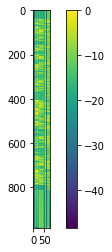

-------------------------------------------------------------------------------------------------------
09-16 02:32:11
09-16 02:33:28
9600/49090
09-16 02:34:56
19200/49090
09-16 02:36:30
28800/49090
09-16 02:38:18
38400/49090
09-16 02:40:31
48000/49090
09-16 02:40:41
Mean Train Loss: 0.06689893479435158
09-16 02:41:13
9600/12272
09-16 02:41:24
Mean Evaluation Loss: 0.07180831245536094


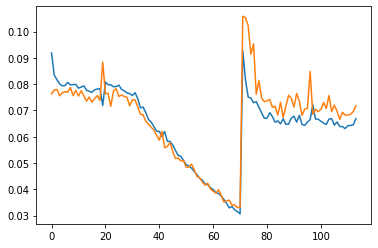

지-------------------------------------------------------게---가---------드---------- -가------느---데-----에----아-----------------------------------------------------------------------------------------.<eos><eos>
지게가드 가느데에아.<eos>
침대 프레임도 다 렌트 해 줄걸?<eos>


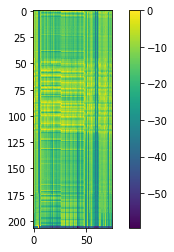

가----------------------------------------  ----------어-----------------------  다-----ᄋ----자-어----데--------ᅥ------------------------------------------------고-------------에-----아--시----드---- 그--아---------거------------------------------------------------------------------------------.<eos><eos>
가 어 다ᄋ자어데ᅥ고에아시드 그아거.<eos>
전 이거 한지 한 팔 개월 됐나? 좀 오래된 거 같은데? 그래가지구<eos>


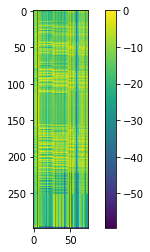

-------------------------------------------------------------------------------------------------------
09-16 02:41:24
09-16 02:42:41
9600/49090
09-16 02:44:08
19200/49090
09-16 02:45:43
28800/49090
09-16 02:47:32
38400/49090
09-16 02:49:46
48000/49090
09-16 02:49:56
Mean Train Loss: 0.06569674196724203
09-16 02:50:28
9600/12272
09-16 02:50:38
Mean Evaluation Loss: 0.06902860127091967


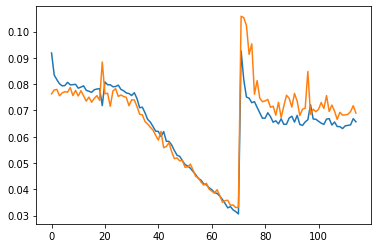

그-----------------------------------------나-------애--에-아---지--으--- 자----가------그---이---ᅡ-- -그----이--ᅡ----- 아----드----구---ᅵ---시---------서-------고------------------------- 이----지------이---시-------가---아-----------시-----그--아-----디----재------서--ᅡ---드--ᄋ---으-ᄋ------------아------------------가----------------드---가--자------------------ᄋ--사---------니--------------------지--지--------------사-------이---어-아---아--시---다---지----가---마--이--이----까-----------------------------------------개---아--아--아---재----이---지------이-오------드--어----지--시--이---사--ᅡ-----시---지------아--아-------드---고----------------저----------------------------------고-------지----으--수--ᅥ---어-------개--아------------------------------------------사---------이------고-----애---ᅵ--가------------가----이----- -가--ᄋ---으--------주----재----아--ᅡ--가----아----자-------ᄋ------------------------------------------------------------------------------------------------------

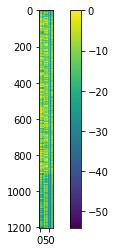

으------------------------------고---으---------드-----------------------------------------------------------------------------------------------------------------------.<eos><eos>
으고으드.<eos>
틀린 부분이 상당히 많은데?<eos>


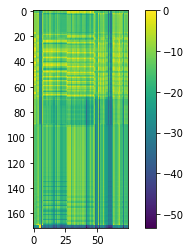

-------------------------------------------------------------------------------------------------------
09-16 02:50:39
09-16 02:51:56
9600/49090
09-16 02:53:23
19200/49090
09-16 02:54:58
28800/49090
09-16 02:56:47
38400/49090
09-16 02:59:01
48000/49090
09-16 02:59:11
Mean Train Loss: 0.06688879711301371
09-16 02:59:43
9600/12272
09-16 02:59:53
Mean Evaluation Loss: 0.07177087552480778


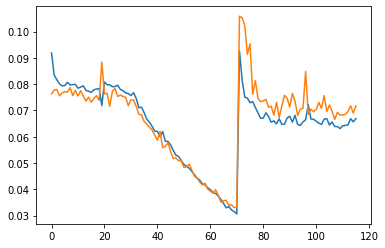

그-----------래-------------서-----에------아-----ᅡ----대-------------------------------------------------------------------------------------------------------.<eos><eos>
그래서에아ᅡ대.<eos>
그래도 은행 사거린데 약간<eos>-----


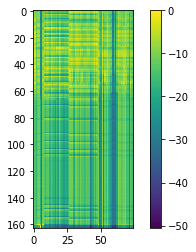

어-------------------------드--------------------------------어-----------------------------------아-----------드-------------------------------------------------ᅩ----------------------------데------------------ᄋ---아-----------대------------------------------------------------------------------------------.<eos><eos>
어드어아드ᅩ데ᄋ아대.<eos>
어 재수생 삼수생 이런 애들이 더 나한테 의지를 하거든.<eos>----------


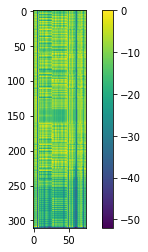

-------------------------------------------------------------------------------------------------------
09-16 02:59:54
09-16 03:01:11
9600/49090
09-16 03:02:39
19200/49090
09-16 03:04:14
28800/49090
09-16 03:06:03
38400/49090
09-16 03:08:16
48000/49090
09-16 03:08:26
Mean Train Loss: 0.0667684507979576
09-16 03:08:58
9600/12272
09-16 03:09:09
Mean Evaluation Loss: 0.06944002610471836


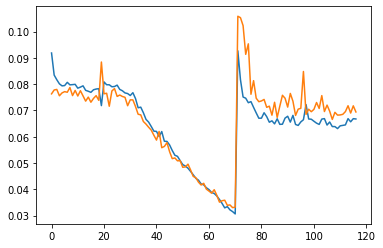

가----------------------------어--고----이--드--오--아----디-----------------------------------------------------------------------------------------------------------------------------.<eos><eos>
가어고이드오아디.<eos>
수능 올 일 등급이었다니까.<eos>---


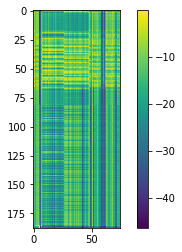

그------------------------------------------------------------------- 가--------사------------고--가-----------------------------------------------------------------.<eos><eos>
그 가사고가.<eos>
걔가 후방주차를 못하더라고<eos>------


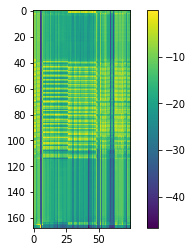

-------------------------------------------------------------------------------------------------------
09-16 03:09:10
09-16 03:10:26
9600/49090
09-16 03:11:53
19200/49090
09-16 03:13:28
28800/49090
09-16 03:15:17
38400/49090
09-16 03:17:31
48000/49090
09-16 03:17:41
Mean Train Loss: 0.06544623411302913
09-16 03:18:14
9600/12272
09-16 03:18:24
Mean Evaluation Loss: 0.07121004797059706


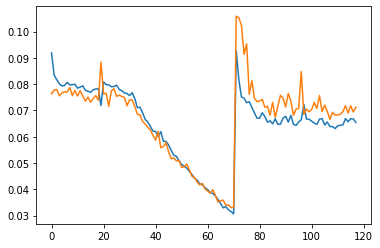

아------------------------으-- -가---지------아--아-아----ᅵ----드-------- 가---------마-----사--------아----그----지---마----ᆫ 나-----시--------디------------고---아--------으------------------------- 다---ᄋ---아-----이--시--------아------------------------------------------- -고--으-- -드--------------------------------------------------------------------------------- 디----고--으------아----------------------------- 지----으----다---아-------아-----가-으----이--가-----사--아-----에---------------------사---- 아--아--아----디---아------으--고------------------------------------------------------------------- 기---------- -자--------으----이------ 드-----으------------------------------------------이------------------------------------------이------디------사------이-----------아------------------------ -이---- 조-------시------이-----이----ᅡ- 나--------지--시----------시-----아--아----------시----ᅡ-----게--아----- 나---애----------고---시--나------지-ᄉ------고-이-----이--------ᅵ-- 가-

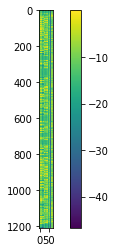

이----------------------------디-----------------------------------데------------------------------------------------아----------디--------나----ᅡ----------느---------------------------------------------------------------------------------------------------------------------------------------------------------------.<eos><eos>
이디데아디나ᅡ느.<eos>
무슨 요일이지? 수요일 일 수요일이랑 일요일만 아니면 되는데.<eos>-


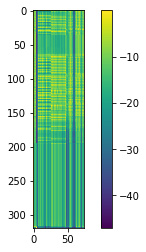

-------------------------------------------------------------------------------------------------------
09-16 03:18:25
09-16 03:19:42
9600/49090
09-16 03:21:09
19200/49090
09-16 03:22:44
28800/49090
09-16 03:24:33
38400/49090
09-16 03:26:47
48000/49090
09-16 03:26:57
Mean Train Loss: 0.06688501644723782
09-16 03:27:29
9600/12272
09-16 03:27:40
Mean Evaluation Loss: 0.07473300227755524


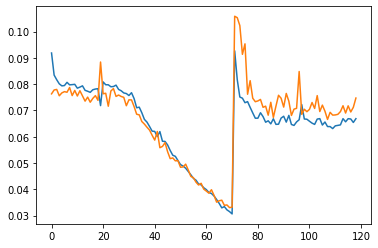

그-----------------------------거------------------시---이-----------지-----지--시--지-----사------거--사-------자-사------거-------------지----------가-----------------거------데--으------ᅳ--------------------거----시--사---자-------거---------거--거-----------------------------시---ᅡ--가-------사---------------------------------------ᄉ-----이----시--시----가----------그--거----거-----------가---가---ᅡ---네---------------데-----------지-----------ᅵ--다------시--가--사-------서----지------드-----------시----지-----지-----서--거--------아------이---드------디--------------------가-------가------가---가-------ᄉ---서------가-----가-------그--시--시-------다---ᅡ-----------------더---시------니--아-------거------가------가-------거---------ᄀ----거-----지---시---지-----지--------ᅥ--------------가-------------ᅡ-------아----ᅡ------더---거-------거---------거-------가--가---------------ᅡ----ᅡ------------------가---------지-------거-------------------------으-------------------------------------

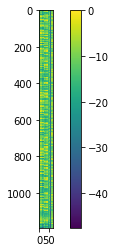

아---------------------------------------- 다----ᅡ------다------가------아--아---가---아------------------------------------------------------------.<eos><eos>
아 다ᅡ다가아아가아.<eos>
다 떨어졌는데 아빠가 왜 화나셔?<eos>-


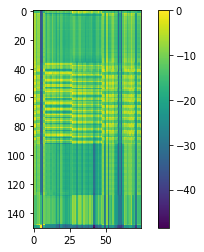

-------------------------------------------------------------------------------------------------------
09-16 03:27:40
09-16 03:28:58
9600/49090
09-16 03:30:25
19200/49090
09-16 03:32:00
28800/49090
09-16 03:33:49
38400/49090
09-16 03:36:03
48000/49090
09-16 03:36:12
Mean Train Loss: 0.07181881936709687
09-16 03:36:45
9600/12272
09-16 03:36:55
Mean Evaluation Loss: 0.07736651811389851


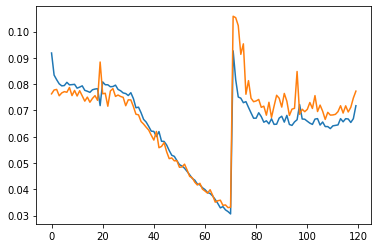

가------------아----이---아- -아- -아--자 -아----  아--아----ᄋ--이----가-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------.<eos><eos>
가아이아 아 아자 아 아아ᄋ이가.<eos>
거기, 뭐 워낙 사람이 많으니까.<eos>--


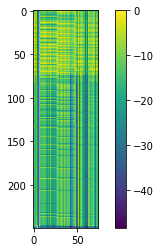

아---------------------------------------------------그-------오---아------아---------지---------오--오-----가--아---오-------가-----------------아-----아----아----아---아----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------.<eos><eos>
아그오아아지오오가아오가아아아아아.<eos>
어. 병문안 와가지구 내가 맹장수술을 얼마 전에 했는데,<eos>---


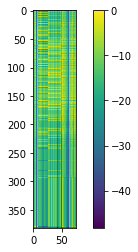

-------------------------------------------------------------------------------------------------------
09-16 03:36:56
09-16 03:38:13
9600/49090
09-16 03:39:40
19200/49090
09-16 03:41:16
28800/49090
09-16 03:43:03
38400/49090
09-16 03:45:16
48000/49090
09-16 03:45:26
Mean Train Loss: 0.06942496655161096
09-16 03:45:58
9600/12272
09-16 03:46:09
Mean Evaluation Loss: 0.07597341023572345


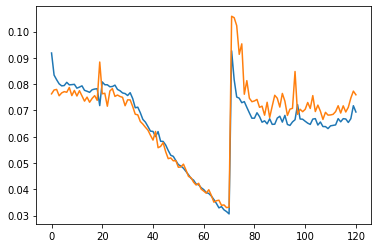

아------------------------이-------------가-------기--이------이-자-------------가-------아나--------------------------------------------------------------------.<eos><eos>
아이가기이이자가아나.<eos>
나는 난 내일 정 정리 할려고.<eos>-


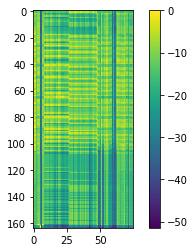

으------------------------------가-----으---ᅡ--어-----고------ᅡ--------고----------------------------------------------------------------------------------------------------.<eos><eos>
으가으ᅡ어고ᅡ고.<eos>
금 동정을 서브를 갖고 해.<eos>----


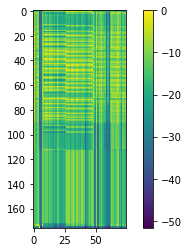

-------------------------------------------------------------------------------------------------------
09-16 03:46:09
09-16 03:47:26
9600/49090
09-16 03:48:53
19200/49090
09-16 03:50:28
28800/49090
09-16 03:52:17
38400/49090
09-16 03:54:30
48000/49090
09-16 03:54:40
Mean Train Loss: 0.06966663836554789
09-16 03:55:12
9600/12272
09-16 03:55:23
Mean Evaluation Loss: 0.07759002341561859


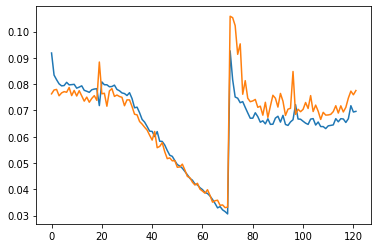

그---------------------------------------------------------------가-----거----------ᅡ-------으--------------------------------------------지--시-------ᅳ--------그---시------가---------------------------------------------------드-----디---아-------가------고-------아------------------------------------------거------------가--------------------------------------시---아-----아---사------시--이-----으-----이-----가-------이---------------디--이---가------으--아----ᅡ-----디--지--고------시------이-----아-----다----------------------------------------------------시------으---이-----ᅳ----------가-----------------------------------------------디-----드-----가--------아------고--노---그---고---가---오--드---드------------사-----드------ᄋ----------가---가-----그---아---------시---아---------------------ᅡ-----가----ᅡ--------------------------------그----그----------------------------가-----ᅡ--아---- 가--------------------으-----가---------고------------------가---------으-----가----------사-----ᄋ

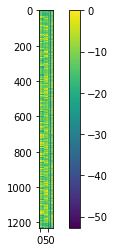

가------------------시----------------------고--------------------------------------------------------------아-----------시------거----------사----시------ᅳ-------------------------------------------------------그--아----시----사-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------.<eos><eos>
가시고아시거사시ᅳ그아시사.<eos>
아 생각만 하고? 그러면 시골에 사시는 그런 친척 있어?<eos>---------


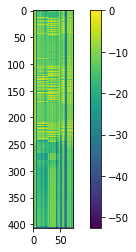

-------------------------------------------------------------------------------------------------------
09-16 03:55:24
09-16 03:56:41
9600/49090
09-16 03:58:08
19200/49090
09-16 03:59:42
28800/49090
09-16 04:01:31
38400/49090
09-16 04:03:45
48000/49090
09-16 04:03:55
Mean Train Loss: 0.07071434750801782
09-16 04:04:27
9600/12272
09-16 04:04:37
Mean Evaluation Loss: 0.07685666869195273


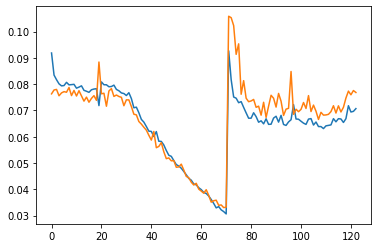

으---------------------------------------------------------- 가-------거--------ᅵ--- 그---- 그--------------------------- 가- 자-------------------------------------------------------그-----아----으------- 가------------가-------ᅳ--- 지-----ᅡ-------고----- 이---------------------------------------------------------------- 지---아-----고--오--오-------ᄋ----------ᅩ-고---ᄋ----- ᄀ------------------------------------------------------가-------아-이--------------- 가---- 으- 드----------지-------------- 가---아-------ᄋ--- -ᅵ------------------------- 고--아----아------------- 지---------------------------  가---------다--아- 사--ᅡ---으--아-------------------드---으- 다-- 가---------------------------------- 그-----------으---아--- 이-----ᄋ-- 지---------- 가----고가--소------- 지-----------------------------------------고----------------기------아-------고--------ᅵ----가--- 다----자--ᅩ--고----이------------------------------- 가----- 자-------------아-- 아---지------------------------- 그-----

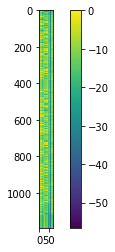

가--------------------------------------------------------------------사----------ᅡ-------------------------------------가---- 고---------------ᅩ---------가----------------------------그-------고----------------- 드-----사------아------ᅡ----------- 가------아-------- 고-----ᅵ--------------------------그-------------------------------- 가------ᅡ---------------ᅡ-------------- 가---- 가--사--------------------------------그--------가---ᅡ--------------------- 가-----ᅳ-------------------가------------------------------------------------ᅡ-----아---- 사--------------------------------고--------------------------서-------------------고--고-------이-----ᅡ---아------ 자----ᅡ--------------------------ᅡ---가---------------------------------------------------------- 그---이--------------------아---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------.<eos><eos>
가사ᅡᄀ

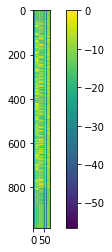

-------------------------------------------------------------------------------------------------------
09-16 04:04:38
09-16 04:05:55
9600/49090
09-16 04:07:22
19200/49090
09-16 04:08:57
28800/49090
09-16 04:10:47
38400/49090
09-16 04:13:01
48000/49090
09-16 04:13:11
Mean Train Loss: 0.07659602144511352
09-16 04:13:43
9600/12272
09-16 04:13:54
Mean Evaluation Loss: 0.07095887208885479


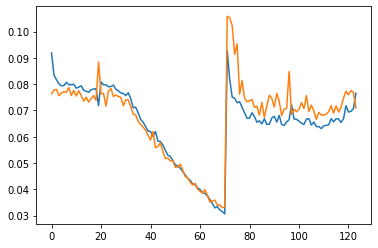

기-------------------------------기-----드-------------- -가-----그----------------------- -가-- 가---이--사--ᄋ------고--아------- 드---으-------------------------------------------- 가--------아------- 가-------ᅵ-----으--가------그--고--자-------ᅡ------------------------------------------가---------------- 가---가------가-----------지-------------그----디-------그-- -가---가----가--가--그--그-가----------ᅳ--------------------------- 그---ᅳ--아---------------------- 기----ᅵ-----------------------그---------ᄀ--지-- 가--------고--고--------------------------------- -고-오-- 그-오--고- 지-------거--즈---드--아-고-------으-----그------ 기----------가-고--이--으---아---가----그---아--오------------------------------------- 가--그----가---ᅳ- 그--ᅳ----- 가---이-이--시-----으--그--지-----지--으---자------------------------------------ -기-----아--아--고---고---------------------- 가-- -가-----가--이--가--고--가---가----고--가----고-그-이--지-----이--어------------------------------------------

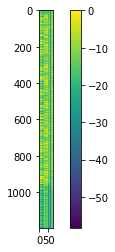

그-----------------------------------------------------------------------디---------------------- 가-------ᅥ----------기-------------------------------------------------그--가-----------------------------가------이----------디---ᄉ--------가----그-----디-----으--가-----ᅵ--지---------------------------------------.<eos><eos>
그디 가ᅥ기그가가이디ᄉ가그디으가ᅵ지.<eos>
그 학교에 은혜 떡볶이 그런 거는 즉석 떡볶이는 아니지?<eos>-------


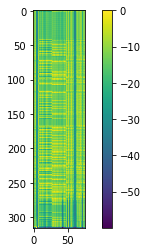

-------------------------------------------------------------------------------------------------------
09-16 04:13:54
09-16 04:15:12
9600/49090
09-16 04:16:39
19200/49090
09-16 04:18:14
28800/49090
09-16 04:20:04
38400/49090
09-16 04:22:17
48000/49090
09-16 04:22:27
Mean Train Loss: 0.07028442585069213
09-16 04:22:59
9600/12272
09-16 04:23:10
Mean Evaluation Loss: 0.07432759976427357


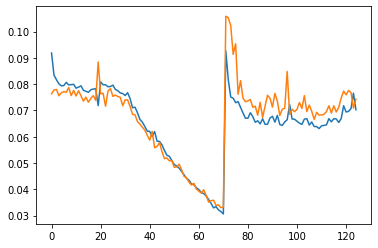

이--------------------디-----자--------그------시--------지------지--------------------------------- 그-----------이--------------이---------------ᅡ------- 고------------------그------고-고---디----------아-------아-----아-------------기-----ᅵ--------------------------- 고----으--아----- 가----아-----ᅡ------------고---그------ -디---가---오--이------------으--이-- -ᅡ-----사--서--------아--ᄋ--으-------- 가----아---------가---시-서------- 가---------------ᅵ------ 그----ᅡ-----ᅳ-----ᅩ---------ᄋ-----------------------이----아--이-----ᄋ-----어-지------오----다--------오-----가-----지----다---아----아------가-------오--아---시----- 가--------시---아---------------ᅩ-------ᄃ-----이-----드-------이----디-----------오-- -기-----지---으---이----이---이-시-----아------시--아--------으---기-----고--------------- --가---으------서-가-----아------ 디-----그---아---이-------------이--------오--ᄋ--지---아----------------------------------------------------------------------------------------------------

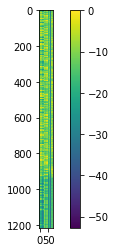

아--------------------디----- 그--으--아----- 거------------------------------거--가------그-----------------그-----------------거----거-----기-------가--------아---가--거---지-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------.<eos><eos>
아디 그으아 거거가그그거거기가아가거지.<eos>
그렇지, 근데 나 얼굴보다는 나는 배랑 허벅지에 살이 많아가지구<eos>


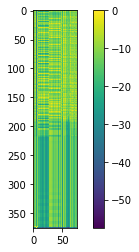

-------------------------------------------------------------------------------------------------------
09-16 04:23:11
09-16 04:24:27
9600/49090
09-16 04:25:54
19200/49090
09-16 04:27:29
28800/49090
09-16 04:29:18
38400/49090
09-16 04:31:31
48000/49090
09-16 04:31:41
Mean Train Loss: 0.07062834722365517
09-16 04:32:13
9600/12272
09-16 04:32:24
Mean Evaluation Loss: 0.08247811697406326


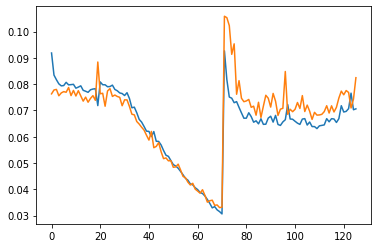

가--------지----------ᄋ------가--고--------------------------------------------------------ᄀ-----------지-------아--------기---으--그----ᅵ---ᄀ---고-------가---------가----ᅩ----고-------------------ᄀ----ᅵ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------.<eos><eos>
가지ᄋ가고ᄀ지아기으그ᅵᄀ고가가ᅩ고기.<eos>
소 혀 먹어봤어? 소 혀가 되게 맛있다고 하더라고 우설 그게.<eos>-------


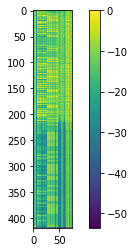

그-----------시-----------------------------------------------------------------ᄀ------가------------------------------------그--------------------이------------그---------------------------가--------------------고------------------------고----------------고----------그-----------------------------------------------------가---그----------------------------------------------------------가-----ᅵ--------------아------사-----그----고----------------------------------------------그----그-----------ᅵ---------ᅳ---------------------------------------ᄀ------------ᅡ---------ᄀ----그----------고------ᅡ--------------------------------------------------------------------고----------------가-----------지-----ᄋ--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

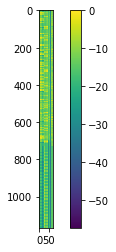

-------------------------------------------------------------------------------------------------------
09-16 04:32:25
09-16 04:33:41
9600/49090
09-16 04:35:08
19200/49090
09-16 04:36:43
28800/49090
09-16 04:38:32
38400/49090
09-16 04:40:46
48000/49090
09-16 04:40:56
Mean Train Loss: 0.07154759037381189
09-16 04:41:28
9600/12272
09-16 04:41:39
Mean Evaluation Loss: 0.07675667237447605


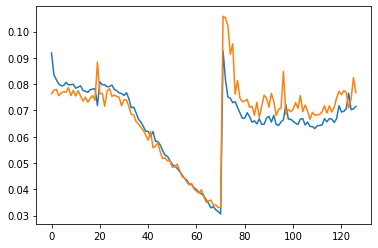

그-------------------드-----자-----아--아--이---아-----------으--아------------------으---으-------으----------으------- 디--------------이--------------------------------- 고------저어----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------.<eos><eos>
그드자아아이아으아으으으으 디이 고저어.<eos>
백 개를 쓰고 한 개를 들어가느냐, 아니면은 열 개를 보고서<eos>------


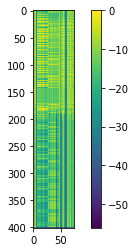

그------------------------------------------------- -가------드----ᅡ----------------------------- 그--아-----------ᅳ-------ᅳ--------- 가-----아-------------------으--------------가--자--------지--- -그--이---아-------드--------------------------------------------------------------------------------------------------------------------.<eos><eos>
그 가드ᅡ 그아ᅳᅳ 가아으가자지 그이아드.<eos>
제가 언제 정도에 그 눈치를 깠냐면? 이제 워크샵 뒤풀이 정도에?<eos>


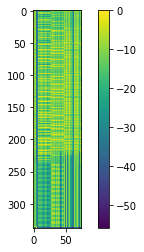

-------------------------------------------------------------------------------------------------------
09-16 04:41:39
09-16 04:42:56
9600/49090
09-16 04:44:23
19200/49090
09-16 04:45:57
28800/49090
09-16 04:47:47
38400/49090
09-16 04:50:02
48000/49090
09-16 04:50:12
Mean Train Loss: 0.06830818092893211
09-16 04:50:44
9600/12272
09-16 04:50:54
Mean Evaluation Loss: 0.07625930230176504


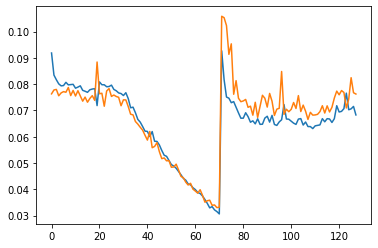

그------------------------ 디--------아----- 가---- 가--으--으--이-----으------------------- 그----ᄋ---아--------------------------- -가------ 가----아- -그------으---- 가----------- 고---------- 그----으-- 거--아----아---------------------------------------------------------.<eos><eos>
그 디아 가 가으으이으 그ᄋ아 가 가아 그으 가 고 그으 거아아.<eos>
낼 때 우리가 그거에 대해서 장학금을 공제받고 내는 거잖아.<eos>-----


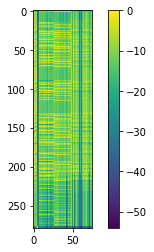

가-----------------------------------------------------가---ᅡ-----아----고--- 고---그  가--- -- 아----- -가---- 고---  가------- -고--고- 고--시---고--거---어------------------------------------------------------------------------------------------------------------------------------------------------------.<eos><eos>
가가ᅡ아고 고그 가  아 가 고 가 고고 고시고거어.<eos>
학교 가서 먹어도 되고 나는 상관없어. 너 먹고 싶은 거 있어?<eos>---


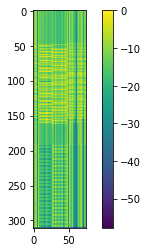

-------------------------------------------------------------------------------------------------------
09-16 04:50:55
09-16 04:52:12
9600/49090
09-16 04:53:38
19200/49090
09-16 04:55:14
28800/49090
09-16 04:57:02
38400/49090
09-16 04:59:16
48000/49090
09-16 04:59:25
Mean Train Loss: 0.06807999090911944
09-16 04:59:57
9600/12272
09-16 05:00:08
Mean Evaluation Loss: 0.07520555364806572


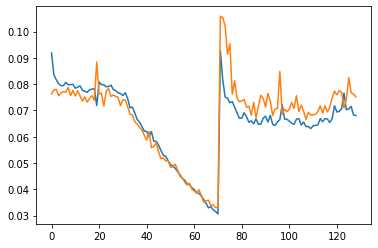

어--------------------------디--시----- 가---- 가----시- -지-  디-시------------다----ᄂ--------------------------------------------------------------------------------------------.<eos><eos>
어디시 가 가시 지 디시다ᄂ.<eos>
시 그 식빵 토스트 또 생각나네.<eos>-


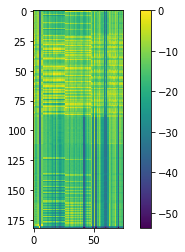

아--------------------------------------------------------------므--시----------아---------드---거--아-----시---고-------------------------아-----가--대-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------.<eos><eos>
아므시아드거아시고아가대.<eos>
음식 만드는 것도 좋아하지. 너 요리학원 한 번 다녀볼래?<eos>------


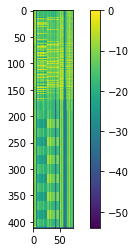

-------------------------------------------------------------------------------------------------------
09-16 05:00:09
09-16 05:01:25
9600/49090
09-16 05:02:52
19200/49090
09-16 05:04:27
28800/49090
09-16 05:06:16
38400/49090
09-16 05:08:30
48000/49090
09-16 05:08:40
Mean Train Loss: 0.06843562239057548
09-16 05:09:12
9600/12272
09-16 05:09:23
Mean Evaluation Loss: 0.07359285873441503


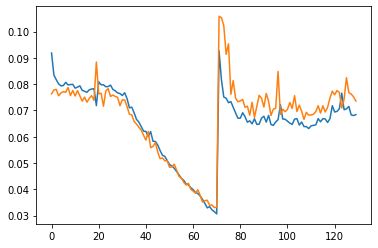

어----------------------------거-----어--이-----이---으---가----------으-어----이----------ᅵ------------------------- -가---아--아---ᄋ--------이--으--어-----ᅡ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------.<eos><eos>
어거어이이으가으어이ᅵ 가아아ᄋ이으어ᅡ.<eos>
물론 공공장소에서 그건 당연한 거지. 당연한 건데도<eos>---------


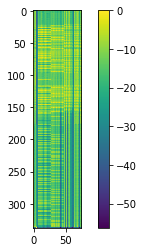

가---------------------가------------이------이---------------아-------그-------------------가-----가--------------------이---------가-------------그-----가------이-------어--어-----------가-----ᅡ------------------------------------------------------------------------------------------------------------------------------------.<eos><eos>
가가이이아그가가이가그가이어어가ᅡ.<eos>
그서 원래 재수한 애들은 초반에는 다 운동 병행해서 하잖아.<eos>---


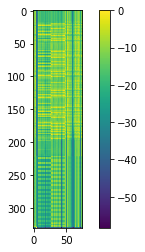

-------------------------------------------------------------------------------------------------------
09-16 05:09:23
09-16 05:10:39
9600/49090
09-16 05:12:07
19200/49090
09-16 05:13:42
28800/49090
09-16 05:15:31
38400/49090
09-16 05:17:46
48000/49090
09-16 05:17:55
Mean Train Loss: 0.06791420411164073
09-16 05:18:27
9600/12272
09-16 05:18:38
Mean Evaluation Loss: 0.07284343917814874


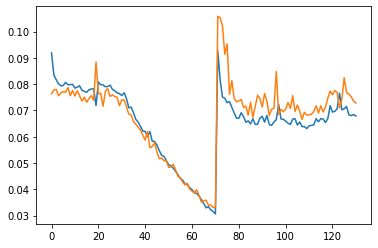

시--------------그----------------------------------드--아--------------아----어----------------------------------------------------------------------------------.<eos><eos>
시그드아아어.<eos>
걔도 근황을 내가 들었어.<eos>-----


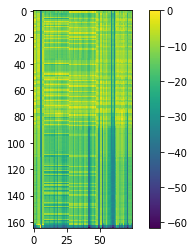

어-----------------------------------------그--지------------------------그---------으--------------고--므-----드---------아---------그---사------아---ᅳ---마----ᅡ--자---어---------------------------------------------------------------------------------------------------------------.<eos><eos>
어그지그으고므드아그사아ᅳ마ᅡ자어.<eos>
뭐 뭐지? 담기한 엘리트 되기랑 그 전에도 뭐 하나 있었어.<eos>---------


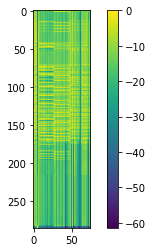

-------------------------------------------------------------------------------------------------------
09-16 05:18:38
09-16 05:19:55
9600/49090
09-16 05:21:23
19200/49090
09-16 05:22:57
28800/49090
09-16 05:24:46
38400/49090
09-16 05:27:00
48000/49090
09-16 05:27:10
Mean Train Loss: 0.0700856863683961
09-16 05:27:42
9600/12272
09-16 05:27:52
Mean Evaluation Loss: 0.07928774826026953


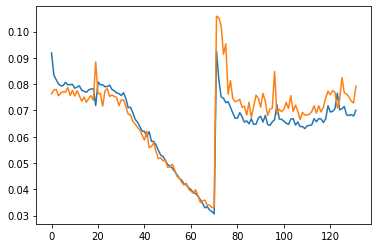

가-------------------------------으---사--------------가--------------------------고-----다-----------고----고----ᅡ------가-고-------가--------------------------ᄃ--------고------기----------------디----------이----으---으-----아--ᄋ---가--------가--------------------------------------------.<eos><eos>
가으사가고다고고ᅡ가고가ᄃ고기디이으으아ᄋ가가.<eos>
근데 저는 옛날부터 어릴 때부터 대게 이 게임기를 많이 접하고<eos>---


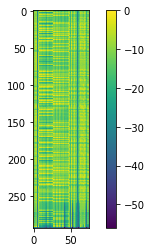

가-------------------------가----------------지--------데----------데-------------------------------------------------------------------------------------------------------------------------------.<eos><eos>
가가지데데.<eos>
버블을 원래 잘 되는데.<eos>--------


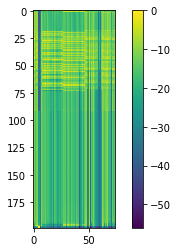

-------------------------------------------------------------------------------------------------------
09-16 05:27:53
09-16 05:29:10
9600/49090
09-16 05:30:37
19200/49090
09-16 05:32:12
28800/49090
09-16 05:34:01
38400/49090
09-16 05:36:14
48000/49090
09-16 05:36:24
Mean Train Loss: 0.0710715544656164
09-16 05:36:56
9600/12272
09-16 05:37:06
Mean Evaluation Loss: 0.07559374094813939


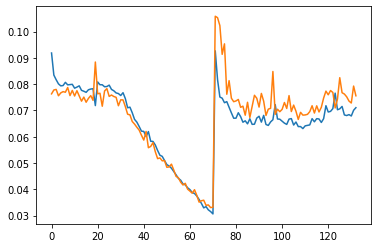

즈-------------------------------ᄅ--에------사-----이------- -ᅡ---------사-------------어---------------------------------------ᅡ--------------------고---------------------------------가----가------ᅳ-----------시--오-----------------------------------------------자---이-------지-------------지--------------------------------.<eos><eos>
즈ᄅ에사이 ᅡ사어ᅡ고가가ᅳ시오자이지지.<eos>
감정 조절에 따라서. 팍 오르고, 아 나는 그랬어. 특히 혈기.<eos>------


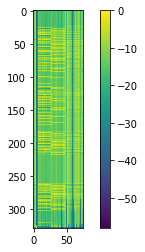

어------------------------------------ -거----ᅵ---사-----------사--------ᅡ-----이-----어-----아----가-------------------자-----어-어------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------.<eos><eos>
어 거ᅵ사사ᅡ이어아가자어어.<eos>
너무 여기저기서 사람들한테 이용만 당하고 있잖아. 지금.<eos>--------


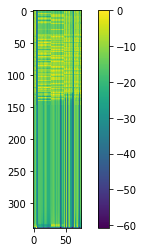

-------------------------------------------------------------------------------------------------------
09-16 05:37:07
09-16 05:38:24
9600/49090
09-16 05:39:52
19200/49090
09-16 05:41:27
28800/49090
09-16 05:43:15
38400/49090
09-16 05:45:28
48000/49090
09-16 05:45:38
Mean Train Loss: 0.06987948641187214
09-16 05:46:10
9600/12272
09-16 05:46:21
Mean Evaluation Loss: 0.07603305277598746


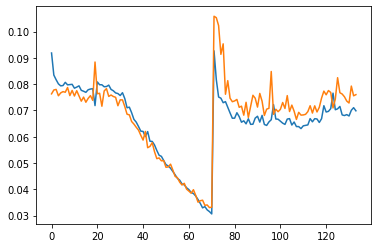

그--------------------ᅡ- 아- 가---자-- 그--- 고---------  가------가------아---아------------  가------ᅡ---아---- 가 가----------------- 그----이-시-----거---- -고-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------.<eos><eos>
그ᅡ 아 가자 그 고 가가아아 가ᅡ아 가 가 그이시거 고.<eos>
저녁까지 먹고 갈 거야? 아니면 그냥 갈 거야? 점심 먹고.<eos>--------


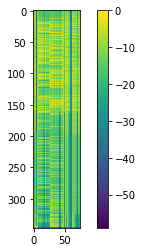

아----------------------------- -마----------------  므----마------------ 미--- 므-----------------------------이------------------------------------------------------------------.<eos><eos>
아 마 므마 미 므이.<eos>
아닌가? 아님 라면에 뭐 이상한<eos>-


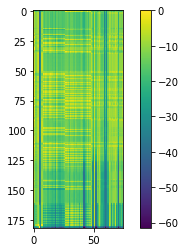

-------------------------------------------------------------------------------------------------------
09-16 05:46:21
09-16 05:47:38
9600/49090
09-16 05:49:05
19200/49090
09-16 05:50:40
28800/49090
09-16 05:52:28
38400/49090
09-16 05:54:41
48000/49090
09-16 05:54:51
Mean Train Loss: 0.06778053773206197
09-16 05:55:23
9600/12272
09-16 05:55:34
Mean Evaluation Loss: 0.07419893320859786


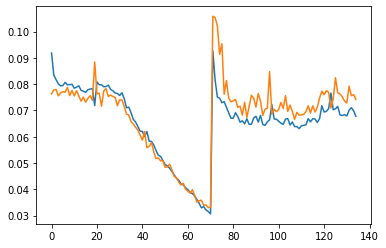

가---------------------------------------------------서--으--아- -가-- -디----아--에--아----아--- -거--아-시------------다----- -지-----지--ᄋ---------------------그---- 가--------------이---자-----가-----------------------------------------------------------------------------------------------------------------------------------------.<eos><eos>
가서으아 가 디아에아아 거아시다 지지ᄋ그 가이자가.<eos>
아니면 쫌 약간 베라에서만 먹을 수 있는 특이한 맛 있잖아.<eos>-


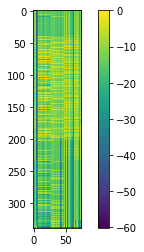

이----------------이---거----- 아----아----아------------------------------------------------------------------------------------------------------------------------------------------------------.<eos><eos>
이이거 아아아.<eos>
요새 니 롤 많이 하드라?<eos>----------


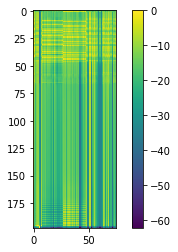

-------------------------------------------------------------------------------------------------------
09-16 05:55:35
09-16 05:56:52
9600/49090
09-16 05:58:19
19200/49090
09-16 05:59:54
28800/49090
09-16 06:01:43
38400/49090
09-16 06:03:56
48000/49090
09-16 06:04:06
Mean Train Loss: 0.06908894562698906
09-16 06:04:38
9600/12272
09-16 06:04:48
Mean Evaluation Loss: 0.07565295507479941


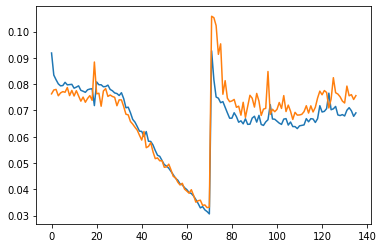

으--------------------------ᅵ---ᅡ-----가----ᅵ--지--------아--------자--------------------------------------------------- 고-----아---아-----시--디--가--아-------------------------------------고----가--고--ᄋ-------------------------------------------------------------------------------------------------------------------------------------------------------------.<eos><eos>
으ᅵᅡ가ᅵ지아자 고아아시디가아고가고ᄋ.<eos>
그 일본에 혹시 지인분은 계세요? 아 혼자 가시는 거에요? 어.<eos>-----


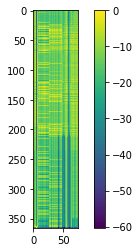

아-------------------------ᅡ--아--아--아---ᅡ--지--아--아--아---거-----아------가-----------ᅡ---ᅡ--지------아---------가--------------------------------- 가---지- -가---다-------------------------------------------------------------------------------------------------------------------------------------------------------------------------.<eos><eos>
아ᅡ아아아ᅡ지아아아거아가ᅡᅡ지아가 가지 가다.<eos>
아이돌 말고 세 곡은 더 안 하고 있었나? 아 매직 카펫 라이드.<eos>--


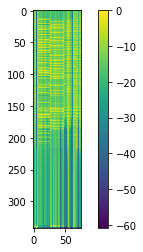

-------------------------------------------------------------------------------------------------------
09-16 06:04:49
09-16 06:06:06
9600/49090
09-16 06:07:34
19200/49090
09-16 06:09:09
28800/49090
09-16 06:10:57
38400/49090
09-16 06:13:11
48000/49090
09-16 06:13:20
Mean Train Loss: 0.0705302141675315
09-16 06:13:52
9600/12272
09-16 06:14:03
Mean Evaluation Loss: 0.07476248420410019


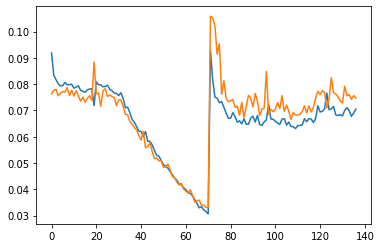

아--------------------------------------------------------------ᅵ---ᄀ--- -가--  고-아-- 가------아--------------------------------------------------------------.<eos><eos>
아ᅵᄀ 가 고아 가아.<eos>
그게 꾸덕꾸덕한 거야?<eos>-----------


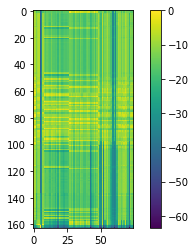

그------------------------------기--------------------------------------------ᅡ- 가---- -고------------------------------------------가---------------------------------------------------------------------------------------------------------------------------------------.<eos><eos>
그기ᅡ 가 고가.<eos>
좀 인기 있는 거 이런 거 찾아가지고 좀 볼려고 하기는 해.<eos>-------


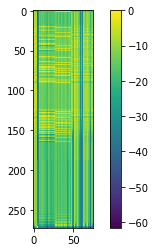

-------------------------------------------------------------------------------------------------------
09-16 06:14:04
09-16 06:15:21
9600/49090
09-16 06:16:48
19200/49090
09-16 06:18:23
28800/49090
09-16 06:20:11
38400/49090
09-16 06:22:25
48000/49090
09-16 06:22:35
Mean Train Loss: 0.0692794365334782
09-16 06:23:07
9600/12272
09-16 06:23:17
Mean Evaluation Loss: 0.08043414745064166


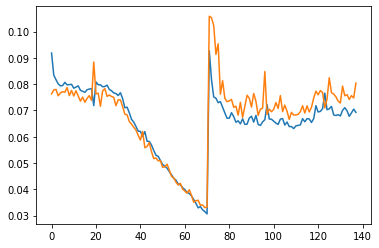

가-------------------------이---가---이----------가-가-------그-이-------------아----아-아---아--------아----------으---가---------ᅩ---지-------그-----이------으---아-----------------이-----------------지---------------지---아-----------------ᅡ------------------------------------거------가--아----------------으-------------------------------------------------------------기-----그--------------------이-----그---고---------이--------가------------아-----가-------아-------시--ᅡ-------그---------------------ᅡ-가--자----아--가--------가---고-----거--------------------가------------------------------------------------------------가--------아------ᅵ-------아----그-기--------------------------------------------이--------------------------------------이-----이--------사----이----이-------아------------------------이-----자----------------이----가----가--가--------이------------------------------아----이----가----------------아-------아--------ᅵ--시--아-------시-아--------이-----그---그-------가

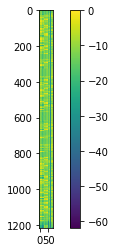

기------------------------사-----------아--------------가----------아---------------------아--------------------------------------------아-----------가----------아------------------------------------------------------------------------------------------------------------------------------------.<eos><eos>
기사아가아아아가아.<eos>
취미 이상 근까 자기 생활 일과를 일과라는 건 일이잖아. 그냥<eos>


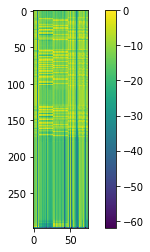

-------------------------------------------------------------------------------------------------------
09-16 06:23:18
09-16 06:24:35
9600/49090
09-16 06:26:02
19200/49090
09-16 06:27:37
28800/49090
09-16 06:29:26
38400/49090
09-16 06:31:41
48000/49090
09-16 06:31:51
Mean Train Loss: 0.07133065071925586
09-16 06:32:23
9600/12272
09-16 06:32:34
Mean Evaluation Loss: 0.07447901297719024


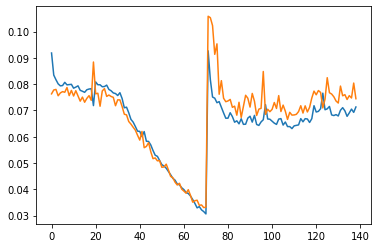

아------------------------------------------------- 고--거---------------가-가---가-가---아--아--고---------고-------------------------가--아------------고--가---가---------------------------------------- 자--------ᄀ-- 그--오---즈---오--가--사------고--오-------으-----가----------------------------가-----가---가------------------------------------가---아--아---------------그---오--고---고--------- 그--으---고--거-----고--------------------------------- 가--가----아-----아----고--으---아--------------시--------그--가--고------고-------고--기---ᄋ----거----------------------------------아--오--고---가------------------가------------------------가--고-가---가---고-고--으------가--고--거---이--이--고--고----기--이-------ᅵ--고-----고--------고---------고----------------  가---고---------------------고---------------------- 가--가----기--------이--아---ᄀ--가--소--------------가--가-----시-----거---ᄋ--거---------ᄀ--------ᄀ---------아--------아---------------------------------------------------

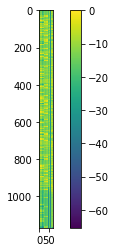

아--------------------------------------가-----------------그------------------------------------------------------------------------------ 가------------------------------------------------------------------------------------------ -가--------ᅡ---------사----가---------오--고-----가--------------고--------------------ᄋ----가--------------ᅡ---------시---------------사---------------------------가--------사---------시------오------가----------------------------------------------가-------------------------가-------고------사----오----고----------그-----고---------이-------ᅵ---------------------------------------------------------------고-------가------가--------------아---ᄋ----ᄋ------------------아--------지---------그-------------이-시-------자--아---고-----아---------아-----------------가----------------------ᄀ-----아--아------이--이-----------ᅡ-------고---------------------아---아----------거----------------------------------------------------------------------------------------------

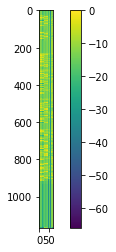

-------------------------------------------------------------------------------------------------------
09-16 06:32:35
09-16 06:33:52
9600/49090
09-16 06:35:19
19200/49090
09-16 06:36:54
28800/49090
09-16 06:38:43
38400/49090
09-16 06:40:57
48000/49090
09-16 06:41:07
Mean Train Loss: 0.06917710359974465
09-16 06:41:39
9600/12272
09-16 06:41:50
Mean Evaluation Loss: 0.0719126431106885


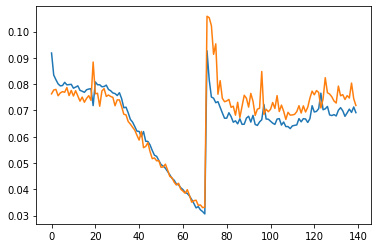

가-------------------------------------------------ᄅ------아---------------ᄋ--아----------가------지---------------------------------------------------------------------------------------------------------------.<eos><eos>
가ᄅ아ᄋ아가지.<eos>
그래도 영화관보단 편하지.<eos>------


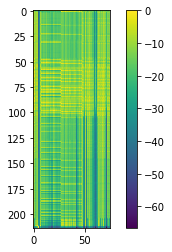

아--------------------------사------------ -자---------가------------------------으-------드--이---------아----------------------------------------------------------------------------------------------.<eos><eos>
아사 자가으드이아.<eos>
그래서 첫날은 렌트해서<eos>---------


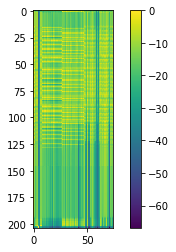

-------------------------------------------------------------------------------------------------------
09-16 06:41:50
09-16 06:43:08
9600/49090
09-16 06:44:35
19200/49090
09-16 06:46:10
28800/49090
09-16 06:47:58
38400/49090
09-16 06:50:12
48000/49090
09-16 06:50:22
Mean Train Loss: 0.06912255107573673
09-16 06:50:55
9600/12272
09-16 06:51:05
Mean Evaluation Loss: 0.0781151092014697


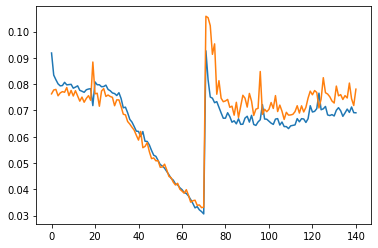

가-------------가--------아-------ᅡ-------으--그---------------------머--------------오----------------- -가----------------오--아------------------------오-- 고------이----가-------오---고-------가----으---아------아----아-가--------디--으--아-----가-----------디-----시-------아------지------아-----가---아----------------------가---------------아--아-------- 가---사----아------아-----아--아--아--가--가--아------이----가----------- -가---------------------자--------ᅡ--가---------------가-----------ᅡ---시-----사--------아---이---아---아-----사--아-----------------------그--아----아----------ᅵ---자-----------------------------가-----ᅡ-----고----아---시--사-----------아----------------디----사----------가--------------ᅳ--고----아------------아------ᅡ--가----------고-----가----- -가------아-----고----어-----그----디--아---아-------그--아-------디---가------아----아-------ᅵ-지------자---아-----가--지---가---------------------------------------------------------------------------------------

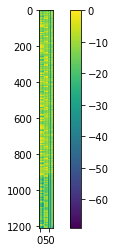

아---------------------------------------------------------머---마----가-------아----------------------------------------------드----아----다------------------------------------------------------------------------------------------------------------------------------------------------------------.<eos><eos>
아머마가아드아다.<eos>
그래가지고 뭐 물가도 싸고, 그래서 멕시코를 많이 가나 봐.<eos>-----------


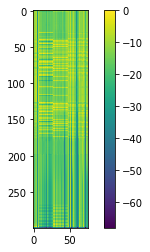

-------------------------------------------------------------------------------------------------------
09-16 06:51:06
09-16 06:52:23
9600/49090
09-16 06:53:50
19200/49090
09-16 06:55:24
28800/49090
09-16 06:57:13
38400/49090
09-16 06:59:26
48000/49090
09-16 06:59:35
Mean Train Loss: 0.06988705812973785
09-16 07:00:08
9600/12272
09-16 07:00:18
Mean Evaluation Loss: 0.07803724799370841


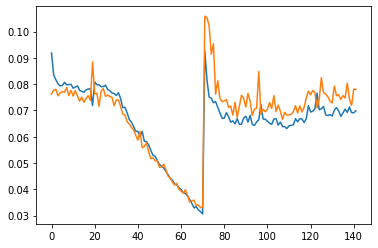

그----------------------------------------------------------다--------------------------------------다---가-----다----가--고--------으----으----------------------------------------------------------이---지-----기-이-----ᅵ--시--- 가----가--그---다----대--지---ᆻ-어-----------------------------------------------------------------------------------------------------------------------------.<eos><eos>
그다다가다가고으으이지기이ᅵ시 가가그다대짔어.<eos>
음 나 같은 경우에는 어렸을 때 미술 학원을 다녔었어.<eos>-------


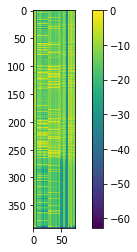

아------------------------ᄀ----------------------------아--아---------------------이--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------.<eos><eos>
아ᄀ아아이.<eos>
그리고 역사는 동아시아씀땜에 포기하고, 그나마 영어 했다, 그나마.<eos>


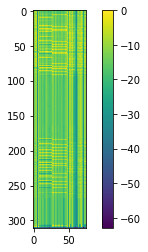

-------------------------------------------------------------------------------------------------------
09-16 07:00:19
09-16 07:01:36
9600/49090
09-16 07:03:03
19200/49090
09-16 07:04:38
28800/49090
09-16 07:06:27
38400/49090
09-16 07:08:41
48000/49090
09-16 07:08:51
Mean Train Loss: 0.07001795567110868
09-16 07:09:23
9600/12272
09-16 07:09:34
Mean Evaluation Loss: 0.07570111496664977


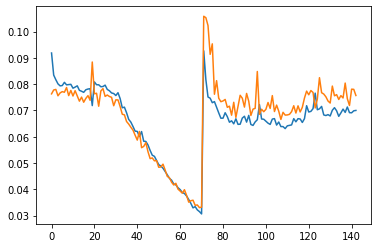

그---------------------------------------------------------------------가-------가------ᅡ----------기-------가---ᅵ----------아--------가---아---------------가----아--------------------사------------------그-------이---------------그------기--------------------------------가---아----ᅳ----------가-으----ᅡ---아--아---기-------가--아-----소-----------------------------가---고------가----오-----가------고-----------------------------------가-----------지-------이--이----------------------------가--------사-------------------가---------가-----------사---사-----이--ᄋ----------지------------------------------------ᅡ----------------자-----------------------------고---ᅡ------사-------------지---------으--다----사---------가-----지-----가------아--------고---ᅡ-------디----으----고-------------------자----------------------------------------------------------------------고------- -가--어--그---아-----지----------------------------------------------------가--이-----------지----가--------고--고-----

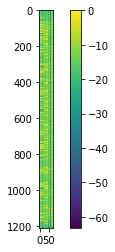

가------------------------------ 가-----------  가- 가-------이----이----그------------------------------------------------------------------------------------------------------------------------------------------.<eos><eos>
가 가 가 가이이그.<eos>
사람 때렸을 것처럼 생기고.<eos>--


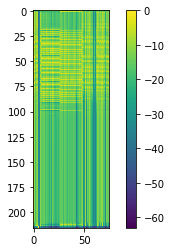

-------------------------------------------------------------------------------------------------------
09-16 07:09:35
09-16 07:10:52
9600/49090
09-16 07:12:19
19200/49090
09-16 07:13:55
28800/49090
09-16 07:15:44
38400/49090
09-16 07:17:58
48000/49090
09-16 07:18:08
Mean Train Loss: 0.07066689034685084
09-16 07:18:40
9600/12272
09-16 07:18:51
Mean Evaluation Loss: 0.07818249469483915


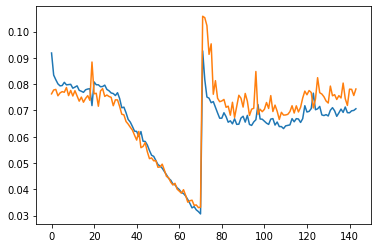

아------------------아-----사--아--아------------------------------------------------------------------------------------- 가---------사--아---시-------지--지------ᅡ---------아-----이---아--아----아------------  지----이------ 가----------가-------------------------------------------------------------------------------------------------------.<eos><eos>
아아사아아 가사아시지지ᅡ아이아아아 지이 가가.<eos>
아 너무 컨셉이 아 솔직히 그럴 사람이 진짜 있긴 한가.<eos>---------


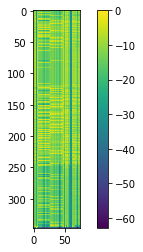

가---------------------------------시---------- 가-------이지-----아------------------------------------------------------------------------------------------------------.<eos><eos>
가시 가이지아.<eos>
그거 시킬 거야? 식권?<eos>----------


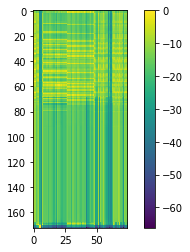

-------------------------------------------------------------------------------------------------------
09-16 07:18:51
09-16 07:20:09
9600/49090
09-16 07:21:36
19200/49090
09-16 07:23:11
28800/49090
09-16 07:25:00
38400/49090
09-16 07:27:14
48000/49090
09-16 07:27:24
Mean Train Loss: 0.07114463134005282
09-16 07:27:56
9600/12272
09-16 07:28:07
Mean Evaluation Loss: 0.07534127888550249


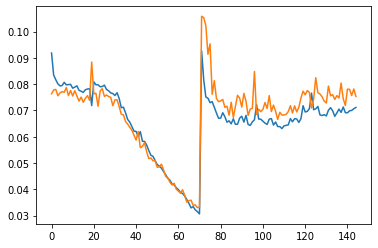

가---------------------------------------------------------------------시----기------------거----아------아---------------------------------------------------------------------------------------------------------------------------------------------------------------------------.<eos><eos>
가시기거아아.<eos>
음, 진짜 오래 만나네?<eos>-----------


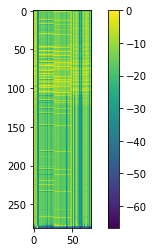

아----------자----가------ 가------아------------------------------------------------------------------------------------------------------------------------------------------.<eos><eos>
아자가 가아.<eos>
아 잠깐만 몇 살이야?<eos>----------


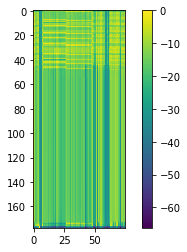

-------------------------------------------------------------------------------------------------------
09-16 07:28:08
09-16 07:29:25
9600/49090
09-16 07:30:52
19200/49090
09-16 07:32:27
28800/49090
09-16 07:34:16
38400/49090
09-16 07:36:31
48000/49090
09-16 07:36:40
Mean Train Loss: 0.07082068911365193
09-16 07:37:13
9600/12272
09-16 07:37:24
Mean Evaluation Loss: 0.07840665953656081


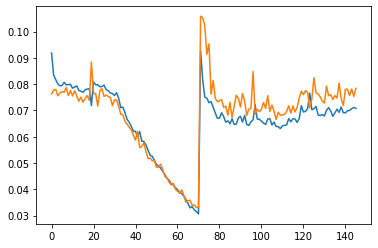

가-----------거그--가--- 그--  아--- 거-  거- 가---어--------------- 가------ 가---------으--- 그-------- -지------ 사-------ᅡ---- 가---- 가---자--------------------------------------------------------------------------------------------------------------------------------------------------------------------------.<eos><eos>
가거그가 그 아 거 거 가어 가 가으 그 지 사ᅡ 가 가자.<eos>
볼만한 게 하나도 없어 아쿠아맨 빼고 진짜 아무것도 없어.<eos>--------


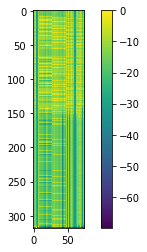

아----------------------------------ᅡ-- 사------ 가-------------거---------------------------------------------------------------------------------------------------------------.<eos><eos>
아ᅡ 사 가거.<eos>
난 그 차 타는 거 너무 좋아.<eos>----


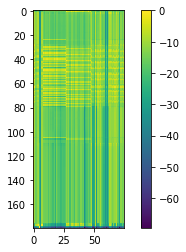

-------------------------------------------------------------------------------------------------------
09-16 07:37:24
09-16 07:38:42
9600/49090
09-16 07:40:09
19200/49090
09-16 07:41:44
28800/49090
09-16 07:43:33
38400/49090
09-16 07:45:47
48000/49090
09-16 07:45:57
Mean Train Loss: 0.07059619052799883
09-16 07:46:29
9600/12272
09-16 07:46:40
Mean Evaluation Loss: 0.08086779309626126


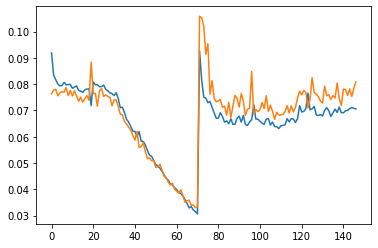

가-----ᄀ-----------기----이----ᄋ--------ᅵ--아-------이----고--아--------------ᅡ--- 자--오------시----기---이-------가----가-------ᄀ-------  가----아--------아---------------------------------------------------------------------------------------------------------------------------------------------.<eos><eos>
가ᄀ기이이아이고아ᅡ 자오시기이가가ᄀ 가아아.<eos>
가장 많은 게 스물 여섯이고 보통 이십 대 초반에서 다 짤라.<eos>-----


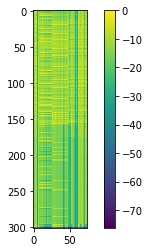

그------------시------------ᅡ--------------------------------------------------------- 가----------------------------------- 가---아--사------아----이------------가---아----------------아---가-------------------  가------------가---아--- 가-----------------오--아-----------가-----아---------아----------------------------- 가---아--아------아-----아--아--사--아---자-------------------  가-----시-------아-----아------아-----그----가-------------------------------------------- -가----기-----------ᅵ-------그-------------------------------------- -가---------------------가---그-------- 가------------------------- 가---------ᄋ------------------------------------ -가--ᄋ---아--시-----ᅡ---아-----지--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

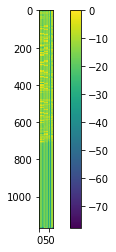

-------------------------------------------------------------------------------------------------------
09-16 07:46:41
09-16 07:47:58
9600/49090
09-16 07:49:26
19200/49090
09-16 07:51:02
28800/49090
09-16 07:52:51
38400/49090
09-16 07:55:05
48000/49090
09-16 07:55:15
Mean Train Loss: 0.07260150585372972
09-16 07:55:47
9600/12272
09-16 07:55:58
Mean Evaluation Loss: 0.07836717967749988


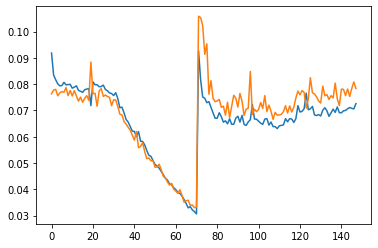

가-------------가-----------------------자------- 기-- 기- 기-- 가---어----- 자- 가-----가------------가------ 가-------------------------- 가---- 기- 자-- 가----아-- 가----ᄋ---------------------------------------------------------------------------------------------------------------------------.<eos><eos>
가가자 기 기 기 가어 자 가가가 가 가 기 자 가아 가ᄋ.<eos>
우리 형이 삼, 사십 불르면 어떡할려고 헐값에 판다 그래.<eos>-------


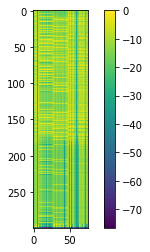

기-------------------- 거---------------------------------------------------- 가--------- 가----- 가------------------------------ 기----- 가----- 가---------- 가-------------------------------------- 가---------------------------------------------------------------------------------------------- 기-------아--------------------------------------------- 가--------------가------------------------.<eos><eos>
기 거 가 가 가 기 가 가 가 가 기아 가가.<eos>
엽떡 난 그냥 기본 매운맛이랑 계란찜이랑 주먹밥.<eos>----------


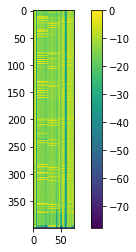

-------------------------------------------------------------------------------------------------------
09-16 07:55:59
09-16 07:57:15
9600/49090
09-16 07:58:43
19200/49090
09-16 08:00:18
28800/49090
09-16 08:02:06
38400/49090
09-16 08:04:20
48000/49090
09-16 08:04:30
Mean Train Loss: 0.07084997828633689
09-16 08:05:02
9600/12272
09-16 08:05:13
Mean Evaluation Loss: 0.08264450861327828


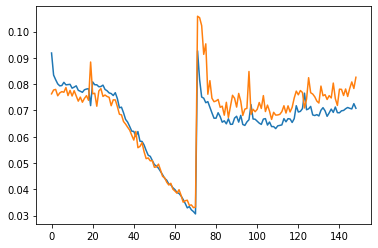

아--------------------------거------------------ᅥ--------------------------이-----가---거----------------------------------------------------------ᄀ----------------------------------------------------.<eos><eos>
아거ᅥ이가거ᄀ.<eos>
어, 아무도 몰라. 니 그거 뭐야.<eos>----


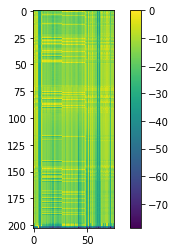

으---------------------그---- 가-- -아----ᅡ--------- -가-------------------------------------------------------------------------------------------------------------.<eos><eos>
으그 가 아ᅡ 가.<eos>
그 잠실 말고도 다른 데도.<eos>-----


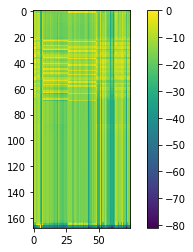

-------------------------------------------------------------------------------------------------------
09-16 08:05:13
09-16 08:06:31
9600/49090
09-16 08:07:58
19200/49090
09-16 08:09:33
28800/49090
09-16 08:11:22
38400/49090
09-16 08:13:37
48000/49090
09-16 08:13:46
Mean Train Loss: 0.07208123722454268
09-16 08:14:19
9600/12272
09-16 08:14:29
Mean Evaluation Loss: 0.07797965184180368


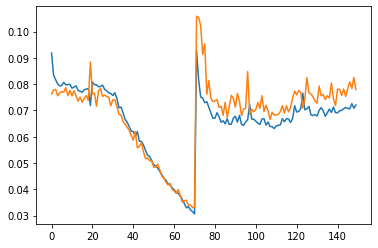

아---------------------사----아------가-- 그--아-------------- 가--- 가--아---아-------아---가--가---------------가---가----가---고--거-----가--사----가------ 가---시------아---어----------------------------------------------------------------------------------------------------------------------------------------.<eos><eos>
아사아가 그아 가 가아아아가가가가가고거가사가 가시아어.<eos>
어쨌든 그랬어. 그것 때문에 내가 연락을 먼저 하고 사귀게 됐어.<eos>


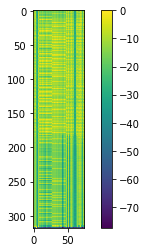

그------------시---------------------고-----------------------------------------고-----그---------------------------------- -그--------------------그------------그---------------------------그--------------------고-----------------기---- 고----------------고---고----그----그----------------거------------------------------고---으-------------------------ᅵ---------기--------------------거---------------------이------이---- 그----고-------고-------------------------------------그-----기---------이-------그-----------ᅵ----------------------------그-----------이------- 그-- 그----------고-------------------------고---------으-------------------------------------거--으------시----가----아-----지--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

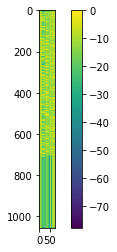

-------------------------------------------------------------------------------------------------------
09-16 08:14:30
09-16 08:15:48
9600/49090
09-16 08:17:16
19200/49090
09-16 08:18:50
28800/49090
09-16 08:20:39
38400/49090
09-16 08:22:54
48000/49090
09-16 08:23:03
Mean Train Loss: 0.07081619858690501
09-16 08:23:36
9600/12272
09-16 08:23:47
Mean Evaluation Loss: 0.08028547927085734


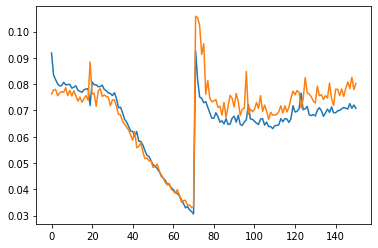

그-----------------이---- 디-- -기----가- 기--- 이---ᆻ어--------------------------------------------------------------------------------------.<eos><eos>
그이 디 기가 기 있어.<eos>
그 느낌 진짜 특이했어.<eos>---------


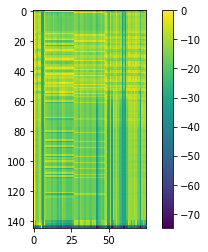

으----------------------------------------------리--- 기------- 이--이--이-----가-------아----------------------------------------------------------------------------------------------------------------------------------------.<eos><eos>
으리 기 이이이가아.<eos>
너 게임은 요즘 뭐 하나.<eos>--------


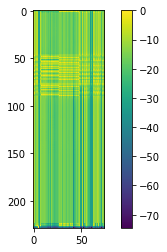

-------------------------------------------------------------------------------------------------------
09-16 08:23:48
09-16 08:25:06
9600/49090
09-16 08:26:33
19200/49090
09-16 08:28:09
28800/49090
09-16 08:29:57
38400/49090
09-16 08:32:12
48000/49090
09-16 08:32:22
Mean Train Loss: 0.07183743845408597
09-16 08:32:53
9600/12272
09-16 08:33:03
Mean Evaluation Loss: 0.07770573061603837


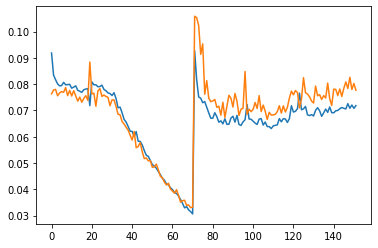

그------------아------아---가---------드----ᅳ--그-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------.<eos><eos>
그아아가드ᅳ그.<eos>
아 너 소조동에서 내렸니?<eos>---------


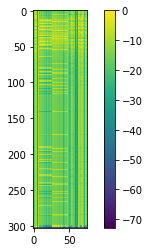

기----------------------시------------------------------지------지----------------가----------------------------------그------ᅵ------ᄀ------------기--이-----------기-----그-----------그----가---아-------------------------이-------------------------------고--고---기--지----------------------가------지--시---------------ᄀ-----------------------------------------------그------------------가-----------그-------ᄋ-------그-----------그---이--사----------가-------가------------------------------------------------------------------ᄃ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------.<eos><eos>
기시지지가그ᅵᄀ기이기그그가아이고고기지가지시ᄀ그가그ᄋ그그이사가가ᄃ.<eos>
되게 인스턴트 느낌의 시인들 있잖아. 그런 시인들을 교수님들이 많이 욕했단 말이야. 이게 무슨 시냐고. 시 이ᄅ

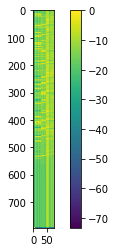

-------------------------------------------------------------------------------------------------------
09-16 08:33:04
09-16 08:34:21
9600/49090
09-16 08:35:48
19200/49090
09-16 08:37:22
28800/49090
09-16 08:39:09
38400/49090
09-16 08:41:23
48000/49090
09-16 08:41:33
Mean Train Loss: 0.07102971437828152
09-16 08:42:05
9600/12272
09-16 08:42:16
Mean Evaluation Loss: 0.07675079968681076


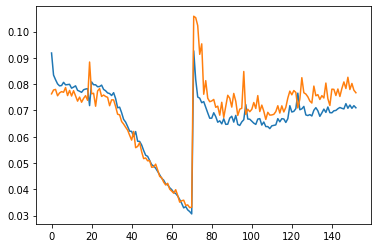

그----------------------------------------그---------아--------아--사---- -가--아------가----------------------------ᅡ-----------------------가---사-----가--------------------------------------------------------------그--아------아-----거--가---가------가-----가----------------------------------.<eos><eos>
그그아아사 가아가ᅡ가사가그아아거가가가가.<eos>
칵테일은 무슨 맛일까? 맛있대? 칵테일 되게 뭐가 많던데<eos>------


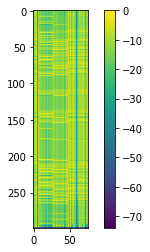

어-----------------ᄀ-----이----------------이--가--아-----------------가-그---이---------이---------아-------------------아---가----이--이---아---------------------------------------그-------------------그----가----가------------기-----------------------거-----------이--------가---------------가-------가-------------가---아------- -가-------가-----------------------------그--으-- -가---아------------이-----------고-----거----------거--거--가---거--으-----그--그--으--아------------거--- -가-----으------그--아--------------가---------------가- 가---아----------가-----아-------그---가-------------------------------------그---------아----------------------그-----아--으-- 가---가----가-------ᅳ-------------------------------------가------아---어---어--거----이--이-----이------가----가-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

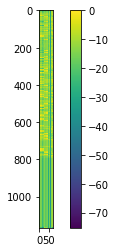

-------------------------------------------------------------------------------------------------------
09-16 08:42:17
09-16 08:43:38
9600/49090


KeyboardInterrupt: 

In [21]:
EPOCH = 6 * 10
    
# 'keyword' determines the save keyword
# Change this keyword if you want to start training a new model
keyword = 'kss-to-ETRI'

# List of loss values
loss_history_train = list()
loss_history_eval = list()

try:
    loss_history_train = np.load('model_saved/loss_history_train_{}.npy'.format(keyword)).tolist()
    loss_history_eval = np.load('model_saved/loss_history_eval_{}.npy'.format(keyword)).tolist()
except:
    print("Loading Failed")
    
# Load model if model weights already exists
try:
    net.load('model_saved/{}'.format(keyword))
except:
    print("Loading Error")
    
for epoch in range(EPOCH):
    
    print(datetime.now().strftime('%m-%d %H:%M:%S'))
    
    net.set_mode('train')
    preloader_train.initialize_batch(num_thread)
    loss_list_train = list()
    
    count = 0
    
    while preloader_train.end_flag == False:
        batch = preloader_train.get_batch()
        if batch != None:
            tensor_input, ground_truth, loss_mask, length_list = batch
            pred_tensor, loss = net.train(tensor_input.to(device), ground_truth.to(device), loss_mask.to(device), length_list.to(device))
            loss_list_train.append(loss)
            count += 1
#         else:
#             print("Empty queue found")
#             print("Thread states: {}".format(preloader_train.thread_flags))
#             print("End flag: {}".format(preloader_train.end_flag))
        
        if (count % 600 == 0):
            print(datetime.now().strftime('%m-%d %H:%M:%S'))
            print('{}/{}'.format(count * batch_size, len(mel_path_list_train)))
#             print("Thread states: {}".format(preloader_train.thread_flags))
#             print("End flag: {}".format(preloader_train.end_flag))
            
#           print('Quese size: {}'.format(preloader_train.queue.qsize()))
            
    print(datetime.now().strftime('%m-%d %H:%M:%S'))
    print("Mean Train Loss: {}".format(np.mean(np.asarray(loss_list_train))))
    loss_history_train.append(np.mean(np.asarray(loss_list_train)))
    
    net.set_mode('eval')
    preloader_eval.initialize_batch(num_thread)
    loss_list_eval = list()
    
    count = 0
    
    while preloader_eval.end_flag == False:
        batch = preloader_eval.get_batch()
        if batch != None:
            tensor_input, ground_truth_, loss_mask, length_list = batch
            pred_tensor_, loss = net.test(tensor_input.to(device), ground_truth_.to(device), loss_mask.to(device), length_list.to(device))
            loss_list_eval.append(loss)
        
        count += 1
        
        if (count % 600 == 0):
            print(datetime.now().strftime('%m-%d %H:%M:%S'))
            print('{}/{}'.format(count * batch_size, len(mel_path_list_eval)))


    print(datetime.now().strftime('%m-%d %H:%M:%S'))
    print("Mean Evaluation Loss: {}".format(np.mean(np.asarray(loss_list_eval))))
    loss_history_eval.append(np.mean(np.asarray(loss_list_eval)))
    
    
    net.save('model_saved/{}'.format(keyword))
    np.save('model_saved/loss_history_train_{}.npy'.format(keyword), loss_history_train)
    np.save('model_saved/loss_history_eval_{}.npy'.format(keyword), loss_history_eval)
    
    
#     if ((epoch != 0) and (epoch % 6 == 0)):
        
    plt.figure()
    plt.plot(loss_history_train)
    plt.plot(loss_history_eval)
    plt.show()

    # index is the position of the max probility of the first batch
    # Shape of the pred_tensor: (T, B, 75)
    # Shape of the index: (T)
    _, index = pred_tensor[:, 0, :].max(-1)

    # Change index numbers to character
    sentence = tokenizer.num2word(index.view(-1))

    # Change list to string
    print(''.join(sentence))

    # Remove "blank" and overlapping characters
    index_ = Decode_CTC_Prediction(index)
    sentence_ = tokenizer.num2word(index_)
    print(''.join(sentence_))

    true_sentence = tokenizer.num2word(ground_truth[0, :].detach().numpy().astype(int))
    print(''.join(true_sentence))

    # Plot image
    # detach().cpu().numpy() transforms a tensor on gpu into a numpy matrix
    plt.figure()
    plt.imshow(pred_tensor[:, 0, :].detach().cpu().numpy())
    plt.colorbar()
    plt.show()

    _, index = pred_tensor_[:, 0, :].max(-1)

    sentence = tokenizer.num2word(index.view(-1))
    print(''.join(sentence))
    index_ = Decode_CTC_Prediction(index)
    sentence_ = tokenizer.num2word(index_)
    print(''.join(sentence_))
    true_sentence = tokenizer.num2word(ground_truth_[0, :].detach().numpy().astype(int))
    print(''.join(true_sentence))

    plt.figure()
    plt.imshow(pred_tensor_[:, 0, :].detach().cpu().numpy())
    plt.colorbar()
    plt.show()



    print("-------------------------------------------------------------------------------------------------------")